# $U(1)$ Gauge Model using L2HMC in graph mode

--------------------------------------------------------------------
### TODO:
* [ ] Look at performance on Cooley (longer training runs).
* [ ] Fit observables to Eq. \ref{eq:therm_time} to determine the thermalization time $\tau$.

\begin{equation} 
f(t) \equiv A \exp^{-t / \tau}+ \,\, B
\label{eq:therm_time}
\end{equation}
* [ ] Look at defining a distance metric as the difference in topological charge between two samples and see what effect adding this as an additional term to the loss function has on the models' ability to tunnel between topological sectors.

--------------------------------------------------------------------

In [1]:
import os
import sys
import time
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.special import i0, i1

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import utils.gauge_model_helpers as helpers
from utils.data_utils import (
    calc_avg_vals_errors, block_resampling, jackknife_err
)
from gauge_model import (
    GaugeModel, check_else_make_dir, save_params_to_pkl_file
)

tfe = tf.contrib.eager
%autoreload 2
%matplotlib notebook

#from gauge_model import GaugeModel
#%reload_ext gauge_model.GaugeModel
#from gauge_model import GaugeModel
#
#from dynamics.gauge_dynamics import GaugeDynamics
#%reload_ext dynamics.gauge_dynamics
#from dynamics.gauge_dynamics import GaugeDynamics

## Define parameters

In [ ]:
tf.reset_default_graph()

In [4]:
params = {
#--------------------- Lattice parameters ----------------------------
    'time_size': 16,
    'space_size': 16,
    'link_type': 'U1',
    'dim': 2,
    'num_samples': 5,
    'rand': False,
    'data_format': 'channels_last',
#--------------------- Leapfrog parameters ---------------------------
    'num_steps': 1,
    'eps': 0.1,
    'loss_scale': 0.1,
    'loss_eps': 1e-4,
#--------------------- Learning rate parameters ----------------------
    'learning_rate_init': 1e-3,
    'learning_rate_decay_steps': 1000,
    'learning_rate_decay_rate': 0.96,
#--------------------- Annealing rate parameters ---------------------
    'annealing': True,
    'annealing_steps': 500,
    'annealing_factor': 0.9999,
    #'beta': 3.,
    'beta_init': 2.,
    'beta_final': 8.,
#--------------------- Training parameters ---------------------------
    'train_steps': 20000,
    'save_steps': 1000,
    'logging_steps': 50,
    'print_steps': 1,
    'training_samples_steps': 1000,
    'training_samples_length': 100,
#--------------------- Model parameters ------------------------------
    'conv_net': True,
    'hmc': False,
    'eps_trainable': True,
    'metric': 'l2',
    'aux': True,
    'clip_grads': False,
    'clip_value': 10.,
    'using_hvd': False
}

## Create model

In [5]:
os.environ["KMP_BLOCKTIME"] = str(0)
os.environ["KMP_SETTINGS"] = str(1)
os.environ["KMP_AFFINITY"] = "granularity=fine,verbose,compact,1,0"
os.environ["OMP_NUM_THREADS"] = str(2)
config = tf.ConfigProto()
tf.reset_default_graph()

In [6]:
model = GaugeModel(params=params, 
                   config=config,
                   sess=None,
                   log_dir=None,
                   restore=False)

save_params_to_pkl_file(params, model.info_dir)

Creating directory for new run: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_103/
Creating directory: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_103/samples_history
Creating directory: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_103/samples_history/training
Creating directory: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_103/train_samples
time_size: 16
space_size: 16
link_type: U1
dim: 2
num_samples: 5
rand: False
data_format: channels_last
num_steps: 1
eps: 0.1
loss_scale: 0.1
loss_eps: 0.0001
learning_rate_init: 0.001
learning_rate_decay_steps: 1000
learning_rate_decay_rate: 0.96
annealing: True
annealing_steps: 500
annealing_factor: 0.9999
beta_init: 2.0
beta_final: 8.0
train_steps: 20000
save_steps: 1000
logging_steps: 50
print_steps: 1
training_samples_steps: 1000
training_samples_length: 100
conv_net: True
hmc: False
eps_trainable: True
metric: l2
aux: True
clip_grads: False
clip_value: 10.0
using_hvd: False
-------------------------------------------------------------

In [ ]:
model.train(model.train_steps, kill_sess=False)

----------------------------------------------------------------------------------------------------
     STEP           LOSS       TIME/STEP      ACCEPT %        EPS           BETA           LR      
----------------------------------------------------------------------------------------------------
     0/20000    -1.717e+05       555.4         0.719          0.1            2           0.001    
     1/20000    -9.273e+04      0.6415        0.4058         0.099           2           0.001    
     2/20000    -1.124e+05      0.5714          0.6         0.09824          2           0.001    
     3/20000    -9.332e+04       0.47         0.6001        0.09758        2.001         0.001    
     4/20000     -5.43e+04      0.4899        0.4002        0.09699        2.001         0.001    
     5/20000    -4.879e+04      0.6247        0.6079        0.09634        2.001         0.001    
     6/20000    -9.206e+04      0.5967         0.686        0.09564        2.001         0.001    
     

    80/20000    -1.086e+05      0.4881        0.9793        0.07684        2.016         0.001    
    81/20000    -1.097e+05      0.4978        0.9689        0.07681        2.016         0.001    
    82/20000    -1.082e+05      0.5434         0.911        0.0768         2.016         0.001    
    83/20000    -1.066e+05      0.4712        0.9486        0.0768         2.017         0.001    
    84/20000    -1.059e+05      0.5532        0.9705        0.07678        2.017         0.001    
    85/20000    -1.092e+05      0.5124        0.9747        0.07674        2.017         0.001    
    86/20000    -1.105e+05       0.577         0.978        0.07671        2.017         0.001    
    87/20000    -1.087e+05      0.6428        0.9506        0.07667        2.017         0.001    
    88/20000    -1.073e+05      0.5036        0.9831        0.07663        2.018         0.001    
    89/20000    -1.083e+05      0.4972        0.9802        0.07656        2.018         0.001    
    90/200

   163/20000    -1.035e+05      0.4696        0.9573        0.07602        2.033         0.001    
   164/20000    -1.007e+05      0.5068        0.9746        0.07598        2.033         0.001    
   165/20000    -1.048e+05      0.4862        0.9617        0.07594        2.033         0.001    
   166/20000    -1.025e+05      0.4863        0.9377        0.07591        2.033         0.001    
   167/20000     -1.04e+05      0.4666        0.9451        0.07585        2.034         0.001    
   168/20000     -1.01e+05      0.4882        0.9832        0.07578        2.034         0.001    
   169/20000    -1.045e+05      0.5019        0.9418        0.07573        2.034         0.001    
   170/20000    -1.075e+05      0.5201        0.9675        0.07568        2.034         0.001    
   171/20000    -1.071e+05       0.479        0.9793        0.07566        2.034         0.001    
   172/20000    -1.011e+05      0.4923        0.9659        0.07563        2.035         0.001    
   173/200

   246/20000     -1.08e+05      0.4813        0.9566        0.07711        2.05          0.001    
   247/20000    -1.032e+05      0.5556           1          0.07722        2.05          0.001    
   248/20000    -1.082e+05      0.5196           1          0.07732        2.05          0.001    
   249/20000    -1.026e+05      0.5621        0.9605        0.0774         2.05          0.001    
   250/20000    -1.049e+05      0.5148        0.9597        0.07749        2.051         0.001    
   251/20000    -1.003e+05      0.5041        0.9723        0.07764        2.051         0.001    
   252/20000    -1.027e+05      0.5951        0.9221        0.0778         2.051         0.001    
   253/20000    -1.046e+05      0.6404        0.9011        0.07798        2.051         0.001    
   254/20000    -1.062e+05      0.5596        0.9348        0.07813        2.051         0.001    
   255/20000    -9.902e+04      0.6373        0.9334        0.07832        2.052         0.001    
   256/200

   329/20000    -1.085e+05      0.5073         0.994        0.08617        2.067         0.001    
   330/20000    -1.048e+05      0.4724        0.9881        0.08638        2.067         0.001    
   331/20000    -1.075e+05      0.4849        0.9493        0.08668        2.067         0.001    
   332/20000    -1.028e+05      0.4594         0.934        0.08695        2.068         0.001    
   333/20000    -1.052e+05      0.4972        0.9725        0.08718        2.068         0.001    
   334/20000     -1.07e+05       0.492        0.9566        0.08744        2.068         0.001    
   335/20000    -1.048e+05      0.4911        0.9695        0.08766        2.068         0.001    
   336/20000    -1.046e+05      0.4694        0.9419        0.08796        2.068         0.001    
   337/20000    -1.036e+05      0.4792        0.9482        0.08823        2.069         0.001    
   338/20000    -1.087e+05      0.4971        0.9328        0.08848        2.069         0.001    
   339/200

   412/20000    -1.079e+05      0.4877        0.9392        0.1035         2.084         0.001    
   413/20000    -1.069e+05      0.4799        0.9985        0.1039         2.084         0.001    
   414/20000    -1.114e+05      0.4941        0.9197        0.1044         2.085         0.001    
   415/20000    -1.047e+05      0.4857        0.9013        0.1049         2.085         0.001    
   416/20000    -9.979e+04      0.4816        0.9516        0.1053         2.085         0.001    
   417/20000    -9.995e+04      0.4804        0.9561        0.1057         2.085         0.001    
   418/20000    -1.006e+05      0.5641        0.8459        0.1061         2.085         0.001    
   419/20000    -1.085e+05      0.4804        0.8786        0.1065         2.086         0.001    
   420/20000    -9.656e+04      0.4987        0.9319        0.1068         2.086         0.001    
   421/20000    -1.084e+05      0.4719        0.9545        0.1073         2.086         0.001    
   422/200

   495/20000    -1.043e+05      0.4845        0.7382        0.1127         2.101         0.001    
   496/20000    -1.055e+05      0.4722        0.9653        0.1129         2.102         0.001    
   497/20000    -1.035e+05      0.4927        0.9246         0.113         2.102         0.001    
   498/20000    -1.056e+05      0.5096         0.901        0.1132         2.102         0.001    
   499/20000    -1.051e+05      0.5251         0.91         0.1134         2.102         0.001    
   500/20000    -1.046e+05      0.4767        0.8368        0.1136         2.103         0.001    
   501/20000    -1.036e+05      0.4817        0.9182        0.1137         2.103         0.001    
   502/20000    -9.873e+04      0.6462        0.7646        0.1138         2.103         0.001    
   503/20000     -1.03e+05      0.4756        0.8687        0.1139         2.103         0.001    
   504/20000    -1.038e+05      0.5013        0.8021        0.1141         2.103         0.001    
   505/200

   578/20000    -1.052e+05      0.4904        0.8181        0.1231         2.119         0.001    
   579/20000    -1.085e+05      0.5262        0.9143        0.1232         2.119         0.001    
   580/20000    -1.027e+05      0.4821        0.9319        0.1234         2.119         0.001    
   581/20000    -1.037e+05      0.4833        0.8164        0.1235         2.12          0.001    
   582/20000    -1.056e+05      0.4712        0.7984        0.1236         2.12          0.001    
   583/20000    -1.059e+05      0.4963        0.9084        0.1236         2.12          0.001    
   584/20000    -1.011e+05      0.4655        0.7416        0.1237         2.12          0.001    
   585/20000    -1.039e+05      0.4882        0.8362        0.1238         2.12          0.001    
   586/20000    -1.041e+05      0.4749        0.6869        0.1239         2.121         0.001    
   587/20000    -1.041e+05      0.4874        0.7414         0.124         2.121         0.001    
   588/200

   661/20000    -1.053e+05      0.5094        0.9367        0.1366         2.137         0.001    
   662/20000    -1.016e+05      0.4519        0.7702        0.1366         2.137         0.001    
   663/20000    -1.053e+05      0.4775        0.7964        0.1366         2.137         0.001    
   664/20000    -1.064e+05      0.4731        0.7449        0.1366         2.137         0.001    
   665/20000    -1.004e+05      0.5082        0.9072        0.1366         2.138         0.001    
   666/20000     -1.01e+05       0.489        0.9238        0.1367         2.138         0.001    
   667/20000    -1.071e+05      0.4873        0.8724        0.1368         2.138         0.001    
   668/20000    -1.028e+05       0.475         0.663        0.1368         2.138         0.001    
   669/20000    -1.014e+05      0.4644        0.7666        0.1372         2.138         0.001    
   670/20000    -9.986e+04      0.5085         0.95         0.1374         2.139         0.001    
   671/200

   744/20000    -1.082e+05      0.5156        0.7741        0.1473         2.154         0.001    
   745/20000    -1.037e+05      0.4655        0.7428        0.1477         2.155         0.001    
   746/20000    -9.998e+04      0.4736        0.6186        0.1482         2.155         0.001    
   747/20000     -1.06e+05      0.5004        0.8293        0.1486         2.155         0.001    
   748/20000    -1.029e+05      0.4914        0.6204        0.1489         2.155         0.001    
   749/20000    -1.032e+05      0.4827        0.7498        0.1492         2.156         0.001    
   750/20000    -9.521e+04      0.5435        0.7761        0.1494         2.156         0.001    
   751/20000    -1.037e+05      0.4692        0.7499        0.1496         2.156         0.001    
   752/20000    -9.934e+04      0.4682        0.9619        0.1497         2.156         0.001    
   753/20000    -1.044e+05      0.5018        0.7767        0.1498         2.156         0.001    
   754/200

   827/20000    -1.022e+05      0.4738        0.7229        0.1496         2.172         0.001    
   828/20000    -1.082e+05      0.4637        0.8761        0.1495         2.173         0.001    
   829/20000    -1.017e+05      0.5019        0.9339        0.1495         2.173         0.001    
   830/20000    -1.037e+05      0.5266        0.6388        0.1494         2.173         0.001    
   831/20000    -1.057e+05      0.4553        0.8203        0.1493         2.173         0.001    
   832/20000    -1.004e+05      0.4809        0.9024        0.1492         2.174         0.001    
   833/20000     -9.88e+04      0.4725        0.6783        0.1493         2.174         0.001    
   834/20000     -1.02e+05      0.4871        0.8709        0.1494         2.174         0.001    
   835/20000    -1.051e+05      0.4985        0.8839        0.1494         2.174         0.001    
   836/20000     -1.01e+05      0.4911        0.7992        0.1495         2.174         0.001    
   837/200

   910/20000    -1.053e+05      0.4975        0.5677         0.146         2.191         0.001    
   911/20000    -1.041e+05      0.5252        0.7503        0.1458         2.191         0.001    
   912/20000    -1.065e+05       0.525        0.9555        0.1456         2.191         0.001    
   913/20000    -1.041e+05      0.4863        0.8188        0.1455         2.191         0.001    
   914/20000    -1.053e+05      0.4826         0.69         0.1453         2.191         0.001    
   915/20000    -1.088e+05      0.4827        0.6913        0.1451         2.192         0.001    
   916/20000    -9.977e+04      0.5019        0.7616        0.1449         2.192         0.001    
   917/20000    -1.041e+05      0.4787        0.9177        0.1447         2.192         0.001    
   918/20000    -1.034e+05      0.4874        0.7643        0.1446         2.192         0.001    
   919/20000    -1.062e+05       0.471        0.6622        0.1444         2.193         0.001    
   920/200

   993/20000    -1.062e+05      0.5205        0.6954        0.1431         2.209         0.001    
   994/20000    -1.073e+05      0.4808        0.9441        0.1432         2.209         0.001    
   995/20000    -1.057e+05      0.4782        0.8737        0.1434         2.209         0.001    
   996/20000    -1.056e+05      0.4674        0.8153        0.1436         2.209         0.001    
   997/20000    -1.048e+05      0.5118        0.7495        0.1438         2.21          0.001    
   998/20000    -1.065e+05      0.4538        0.8566         0.144         2.21          0.001    
Saving checkpoint to: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_103/model.ckpt
   999/20000    -1.011e+05       0.816        0.7663        0.1441         2.21          0.001    
--------------------------------------------------------------------------------

Evaluating sampler for 100 steps at beta = 8.0.
Running (trained) L2HMC sampler for 100 steps...
step:      0/100    accept prob (avg):     1

  1049/20000     -1.05e+05      0.5252        0.8271        0.1445         2.221        0.00096   
  1050/20000    -1.098e+05       0.515           1          0.1444         2.221        0.00096   
  1051/20000    -1.028e+05      0.5202        0.7159        0.1443         2.222        0.00096   
  1052/20000    -1.044e+05      0.4893        0.6757        0.1442         2.222        0.00096   
  1053/20000    -1.011e+05       0.519        0.9019         0.144         2.222        0.00096   
  1054/20000    -1.044e+05      0.4793        0.7486        0.1439         2.222        0.00096   
  1055/20000    -9.925e+04      0.4886        0.8823        0.1437         2.223        0.00096   
  1056/20000    -1.011e+05      0.4799        0.8103         0.144         2.223        0.00096   
  1057/20000    -9.952e+04      0.4872        0.8041        0.1442         2.223        0.00096   
  1058/20000    -1.051e+05      0.5388        0.7386        0.1446         2.223        0.00096   
  1059/200

  1132/20000    -1.019e+05      0.4741        0.7663        0.1502         2.24         0.00096   
  1133/20000    -1.013e+05       0.517        0.7558         0.15          2.24         0.00096   
  1134/20000     -1.04e+05      0.5084        0.9436        0.1499         2.24         0.00096   
  1135/20000    -1.043e+05      0.5075        0.8744        0.1497         2.24         0.00096   
  1136/20000    -9.923e+04      0.4833        0.6803        0.1495         2.241        0.00096   
  1137/20000    -1.034e+05      0.4831        0.6845        0.1494         2.241        0.00096   
  1138/20000    -1.034e+05      0.4787        0.6437        0.1491         2.241        0.00096   
  1139/20000    -1.045e+05      0.5624        0.8675        0.1489         2.241        0.00096   
  1140/20000     -1.03e+05      0.4257        0.7872        0.1487         2.242        0.00096   
  1141/20000    -1.024e+05      0.4546        0.7905        0.1485         2.242        0.00096   
  1142/200

  1215/20000    -1.064e+05      0.4723        0.6927        0.1473         2.258        0.00096   
  1216/20000    -1.054e+05       0.493        0.8297        0.1473         2.259        0.00096   
  1217/20000    -9.891e+04      0.4871        0.6763        0.1472         2.259        0.00096   
  1218/20000    -1.029e+05       0.514         0.688        0.1473         2.259        0.00096   
  1219/20000    -1.021e+05      0.4823        0.7104        0.1473         2.259        0.00096   
  1220/20000    -1.061e+05      0.4819        0.8605        0.1473         2.26         0.00096   
  1221/20000    -1.006e+05      0.4782        0.7287        0.1473         2.26         0.00096   
  1222/20000    -1.023e+05      0.4988         0.62         0.1472         2.26         0.00096   
  1223/20000    -1.046e+05      0.5181         0.747        0.1472         2.26         0.00096   
  1224/20000    -1.038e+05      0.5278        0.8295        0.1471         2.26         0.00096   
  1225/200

  1298/20000    -1.042e+05      0.4835        0.5202        0.1485         2.277        0.00096   
  1299/20000    -1.055e+05      0.4748           1          0.1485         2.277        0.00096   
  1300/20000    -1.039e+05      0.4834        0.8683        0.1486         2.278        0.00096   
  1301/20000    -9.925e+04       0.499        0.5428        0.1486         2.278        0.00096   
  1302/20000    -1.058e+05      0.5029        0.8219        0.1485         2.278        0.00096   
  1303/20000    -1.058e+05      0.5166        0.6545        0.1485         2.278        0.00096   
  1304/20000    -1.047e+05      0.4856        0.8031        0.1484         2.279        0.00096   
  1305/20000    -1.044e+05      0.4827        0.7014        0.1483         2.279        0.00096   
  1306/20000    -9.854e+04      0.4663        0.6793        0.1482         2.279        0.00096   
  1307/20000     -1.05e+05      0.4763        0.7527        0.1484         2.279        0.00096   
  1308/200

  1381/20000    -1.038e+05      0.4845         0.813        0.1413         2.296        0.00096   
  1382/20000    -1.054e+05      0.5246        0.8215        0.1411         2.296        0.00096   
  1383/20000    -1.035e+05      0.4679         0.697        0.1409         2.297        0.00096   
  1384/20000    -1.014e+05      0.6023        0.7141        0.1407         2.297        0.00096   
  1385/20000    -1.034e+05      0.6561        0.8198        0.1405         2.297        0.00096   
  1386/20000    -9.164e+04       0.509        0.9538        0.1403         2.297        0.00096   
  1387/20000     -1.05e+05      0.9562        0.8791        0.1401         2.298        0.00096   
  1388/20000    -1.054e+05      0.7319        0.8045        0.1399         2.298        0.00096   
  1389/20000    -1.047e+05      0.5696        0.9452        0.1397         2.298        0.00096   
  1390/20000     -1.04e+05      0.5079        0.8077        0.1395         2.298        0.00096   
  1391/200

  1464/20000      -1e+05        0.5301        0.6393        0.1311         2.315        0.00096   
  1465/20000    -1.035e+05      0.5504        0.9347        0.1313         2.316        0.00096   
  1466/20000    -1.023e+05      0.5078        0.8238        0.1314         2.316        0.00096   
  1467/20000    -1.041e+05      0.5024        0.7263        0.1316         2.316        0.00096   
  1468/20000    -1.077e+05      0.5217        0.6253        0.1316         2.316        0.00096   
  1469/20000    -1.052e+05      0.5481        0.7659        0.1317         2.316        0.00096   
  1470/20000    -1.027e+05      0.5513        0.8372        0.1317         2.317        0.00096   
  1471/20000    -1.008e+05      0.5346        0.8064        0.1317         2.317        0.00096   
  1472/20000    -1.044e+05      0.5316        0.9543        0.1317         2.317        0.00096   
  1473/20000    -1.063e+05      0.5565        0.8156        0.1316         2.317        0.00096   
  1474/200

  1547/20000     -1.02e+05      0.4908        0.6559        0.1306         2.335        0.00096   
  1548/20000     -1.01e+05      0.4967        0.7499        0.1305         2.335        0.00096   
  1549/20000    -1.045e+05      0.5115        0.9172        0.1304         2.335        0.00096   
  1550/20000    -1.029e+05      0.5725        0.6826        0.1303         2.335        0.00096   
  1551/20000    -1.056e+05      0.5124        0.8832        0.1301         2.336        0.00096   
  1552/20000    -9.671e+04      0.5477        0.9189         0.13          2.336        0.00096   
  1553/20000     -1.05e+05      0.5292        0.8261        0.1299         2.336        0.00096   
  1554/20000    -1.026e+05      0.5778        0.7629        0.1298         2.336        0.00096   
  1555/20000    -1.044e+05      0.5245        0.9559        0.1296         2.337        0.00096   
  1556/20000    -1.029e+05      0.5381        0.8674        0.1295         2.337        0.00096   
  1557/200

  1630/20000    -1.028e+05      0.4877        0.6295        0.1321         2.354        0.00096   
  1631/20000    -1.051e+05      0.5175         0.626        0.1321         2.354        0.00096   
  1632/20000    -1.036e+05      0.5057        0.7083         0.132         2.355        0.00096   
  1633/20000    -1.017e+05      0.5163        0.7538        0.1319         2.355        0.00096   
  1634/20000    -1.074e+05      0.4884        0.9484        0.1322         2.355        0.00096   
  1635/20000    -1.023e+05      0.5064        0.8871        0.1325         2.355        0.00096   
  1636/20000    -1.007e+05       0.502        0.8387        0.1328         2.356        0.00096   
  1637/20000    -1.023e+05       0.493        0.6337         0.133         2.356        0.00096   
  1638/20000    -1.011e+05      0.5418        0.7893        0.1331         2.356        0.00096   
  1639/20000    -1.051e+05      0.5024        0.9968        0.1332         2.356        0.00096   
  1640/200

  1713/20000    -1.028e+05      0.5621        0.6461        0.1357         2.374        0.00096   
  1714/20000    -9.397e+04      0.5591        0.8997        0.1364         2.374        0.00096   
  1715/20000    -1.034e+05      0.5557        0.7094        0.1373         2.374        0.00096   
  1716/20000    -1.027e+05      0.5849        0.9449        0.1381         2.374        0.00096   
  1717/20000    -1.016e+05      0.5244        0.9198        0.1393         2.375        0.00096   
  1718/20000    -1.046e+05      0.5049        0.7852        0.1404         2.375        0.00096   
  1719/20000    -1.067e+05      0.5169        0.6924        0.1413         2.375        0.00096   
  1720/20000    -1.016e+05      0.5171         0.805        0.1421         2.375        0.00096   
  1721/20000    -1.037e+05      0.5452        0.7044        0.1428         2.376        0.00096   
  1722/20000     -1.06e+05      0.5347        0.7017        0.1434         2.376        0.00096   
  1723/200

  1796/20000    -1.028e+05       0.492        0.6322        0.1389         2.393        0.00096   
  1797/20000    -1.044e+05      0.5528        0.9504        0.1391         2.394        0.00096   
  1798/20000    -1.009e+05       0.479         0.837        0.1392         2.394        0.00096   
  1799/20000     -1.06e+05      0.4959        0.7279        0.1393         2.394        0.00096   
  1800/20000    -1.057e+05      0.5148           1          0.1394         2.394        0.00096   
  1801/20000    -1.029e+05      0.4701        0.9157        0.1394         2.395        0.00096   
  1802/20000    -1.023e+05      0.4953        0.7414        0.1395         2.395        0.00096   
  1803/20000    -1.078e+05      0.4774        0.8594        0.1395         2.395        0.00096   
  1804/20000    -1.066e+05      0.5989        0.9306        0.1395         2.395        0.00096   
  1805/20000    -1.016e+05      0.4877        0.6994        0.1395         2.396        0.00096   
  1806/200

  1879/20000    -1.036e+05      0.4714        0.7496        0.1407         2.413        0.00096   
  1880/20000     -9.9e+04       0.5056        0.5675        0.1407         2.414        0.00096   
  1881/20000    -1.019e+05      0.4907        0.7338        0.1407         2.414        0.00096   
  1882/20000    -1.019e+05      0.4807        0.8947        0.1407         2.414        0.00096   
  1883/20000    -1.027e+05      0.4769        0.6888        0.1407         2.414        0.00096   
  1884/20000    -1.094e+05      0.4885        0.8802        0.1406         2.415        0.00096   
  1885/20000    -1.044e+05      0.5268        0.9144        0.1405         2.415        0.00096   
  1886/20000    -9.795e+04      0.4909         0.974        0.1405         2.415        0.00096   
  1887/20000    -1.022e+05      0.4961        0.6653        0.1404         2.415        0.00096   
  1888/20000     -1.06e+05      0.4882        0.8899        0.1403         2.416        0.00096   
  1889/200

  1962/20000    -9.904e+04       0.47         0.7131         0.136         2.434        0.00096   
  1963/20000    -1.024e+05      0.4672        0.8298        0.1362         2.434        0.00096   
  1964/20000    -1.059e+05      0.5126         0.724        0.1363         2.434        0.00096   
  1965/20000    -1.043e+05      0.5253        0.8869        0.1365         2.434        0.00096   
  1966/20000    -1.038e+05       0.463        0.6842        0.1366         2.435        0.00096   
  1967/20000    -1.004e+05      0.4861        0.7504        0.1366         2.435        0.00096   
  1968/20000    -1.047e+05      0.4801        0.8746        0.1366         2.435        0.00096   
  1969/20000    -1.086e+05      0.5061        0.9269        0.1366         2.435        0.00096   
  1970/20000     -1.03e+05      0.4883         0.947        0.1366         2.436        0.00096   
  1971/20000    -1.039e+05      0.4801        0.8395        0.1366         2.436        0.00096   
  1972/200

  2019/20000    -9.866e+04      0.4732        0.8809        0.1355         2.447       0.0009216  
  2020/20000    -1.009e+05      0.5019        0.8029        0.1357         2.448       0.0009216  
  2021/20000    -1.034e+05       0.479        0.7111        0.1358         2.448       0.0009216  
  2022/20000    -9.924e+04       0.472         0.808        0.1359         2.448       0.0009216  
  2023/20000    -1.045e+05      0.5413        0.8388         0.136         2.448       0.0009216  
  2024/20000    -9.957e+04      0.5473        0.7427        0.1361         2.449       0.0009216  
  2025/20000    -1.058e+05      0.7912        0.9193        0.1362         2.449       0.0009216  
  2026/20000     -1.05e+05      0.6821        0.8183        0.1364         2.449       0.0009216  
  2027/20000    -1.032e+05      0.4801        0.8746        0.1365         2.449       0.0009216  
  2028/20000    -1.028e+05      0.4694        0.7934        0.1366         2.45        0.0009216  
  2029/200

  2102/20000    -1.024e+05      0.4837        0.8052        0.1348         2.468       0.0009216  
  2103/20000    -1.049e+05      0.4732        0.7848        0.1346         2.468       0.0009216  
  2104/20000    -1.074e+05      0.5315        0.8843        0.1349         2.468       0.0009216  
  2105/20000    -1.027e+05      0.4681        0.8914        0.1352         2.469       0.0009216  
  2106/20000    -1.049e+05      0.5337        0.8136        0.1354         2.469       0.0009216  
  2107/20000    -1.034e+05      0.5229        0.6435        0.1356         2.469       0.0009216  
  2108/20000    -1.025e+05      0.4862        0.7884        0.1357         2.469       0.0009216  
  2109/20000    -1.064e+05      0.4935        0.7944        0.1358         2.47        0.0009216  
  2110/20000    -1.011e+05      0.4831        0.8014        0.1358         2.47        0.0009216  
  2111/20000    -1.026e+05      0.4782        0.8034        0.1358         2.47        0.0009216  
  2112/200

  2185/20000     -1.04e+05      0.4664        0.7738        0.1425         2.488       0.0009216  
  2186/20000    -1.028e+05      0.6025        0.8736        0.1422         2.489       0.0009216  
  2187/20000    -1.079e+05      0.5021        0.9308         0.142         2.489       0.0009216  
  2188/20000    -1.055e+05      0.5773        0.8384        0.1419         2.489       0.0009216  
  2189/20000    -1.003e+05       1.087        0.8394        0.1416         2.489       0.0009216  
  2190/20000    -1.014e+05      0.7132        0.8189        0.1414         2.49        0.0009216  
  2191/20000    -1.031e+05      0.5554         0.752        0.1413         2.49        0.0009216  
  2192/20000    -1.007e+05       0.486        0.6798        0.1411         2.49        0.0009216  
  2193/20000    -1.023e+05      0.4783        0.8444        0.1409         2.49        0.0009216  
  2194/20000    -1.018e+05      0.5099        0.6336        0.1407         2.491       0.0009216  
  2195/200

  2268/20000    -1.059e+05      0.4602        0.7282        0.1412         2.509       0.0009216  
  2269/20000    -1.011e+05      0.5074        0.8358        0.1412         2.509       0.0009216  
  2270/20000     -1.02e+05      0.4681        0.8756        0.1411         2.51        0.0009216  
  2271/20000    -1.068e+05      0.5175        0.8868        0.1411         2.51        0.0009216  
  2272/20000    -1.021e+05      0.5038        0.9085         0.141         2.51        0.0009216  
  2273/20000     -1.05e+05      0.5413        0.6509         0.141         2.51        0.0009216  
  2274/20000    -1.025e+05      0.5185        0.6199        0.1409         2.511       0.0009216  
  2275/20000    -1.076e+05      0.4747        0.7911        0.1408         2.511       0.0009216  
  2276/20000    -1.068e+05      0.4681        0.7254        0.1407         2.511       0.0009216  
  2277/20000    -9.984e+04      0.5103        0.6675        0.1406         2.511       0.0009216  
  2278/200

  2351/20000    -1.028e+05      0.4821        0.6865        0.1415         2.53        0.0009216  
  2352/20000    -1.052e+05      0.4742         0.868        0.1412         2.53        0.0009216  
  2353/20000    -1.061e+05       0.485          0.7          0.141         2.531       0.0009216  
  2354/20000    -1.028e+05      0.4987        0.7719        0.1407         2.531       0.0009216  
  2355/20000    -1.002e+05      0.4854        0.8472        0.1405         2.531       0.0009216  
  2356/20000    -1.029e+05      0.5005        0.8314        0.1402         2.531       0.0009216  
  2357/20000     -1.05e+05      0.4824        0.8139         0.14          2.532       0.0009216  
  2358/20000    -9.988e+04      0.4812         0.737        0.1397         2.532       0.0009216  
  2359/20000    -1.045e+05      0.4941        0.8192        0.1395         2.532       0.0009216  
  2360/20000    -9.996e+04       0.536        0.8842        0.1392         2.532       0.0009216  
  2361/200

  2434/20000    -1.016e+05      0.4843         0.841        0.1308         2.551       0.0009216  
  2435/20000    -1.013e+05       0.514        0.7572        0.1306         2.551       0.0009216  
  2436/20000    -9.939e+04      0.4779        0.7282        0.1304         2.552       0.0009216  
  2437/20000    -1.044e+05      0.4966        0.5843        0.1302         2.552       0.0009216  
  2438/20000    -9.291e+04      0.4649        0.7134         0.13          2.552       0.0009216  
  2439/20000    -1.042e+05      0.4967        0.8582        0.1302         2.552       0.0009216  
  2440/20000    -1.045e+05      0.4978        0.7943        0.1304         2.553       0.0009216  
  2441/20000    -1.054e+05      0.5556        0.5909        0.1305         2.553       0.0009216  
  2442/20000    -1.013e+05      0.4676        0.7903        0.1305         2.553       0.0009216  
  2443/20000    -9.877e+04       0.483        0.6458        0.1306         2.553       0.0009216  
  2444/200

  2517/20000    -1.026e+05      0.5159        0.7944        0.1281         2.572       0.0009216  
  2518/20000    -1.047e+05      0.5167        0.6335        0.1279         2.573       0.0009216  
  2519/20000     -1.04e+05      0.4838        0.9167        0.1277         2.573       0.0009216  
  2520/20000    -1.059e+05      0.5152        0.7659        0.1276         2.573       0.0009216  
  2521/20000    -1.008e+05      0.4853        0.8676        0.1274         2.573       0.0009216  
  2522/20000    -1.023e+05      0.4947         0.734        0.1273         2.574       0.0009216  
  2523/20000    -1.014e+05      0.4717        0.7336        0.1271         2.574       0.0009216  
  2524/20000     -1.07e+05      0.4951        0.6798        0.1271         2.574       0.0009216  
  2525/20000    -1.044e+05      0.5687        0.7469        0.1271         2.575       0.0009216  
  2526/20000    -1.014e+05      0.8738        0.8759        0.1271         2.575       0.0009216  
  2527/200

  2600/20000    -1.034e+05      0.4901         0.828         0.134         2.594       0.0009216  
  2601/20000    -1.046e+05      0.5327        0.6378        0.1339         2.594       0.0009216  
  2602/20000    -1.019e+05      0.4951         0.941        0.1338         2.594       0.0009216  
  2603/20000    -1.032e+05      0.4726        0.5419        0.1337         2.595       0.0009216  
  2604/20000    -1.041e+05      0.5032        0.8288        0.1335         2.595       0.0009216  
  2605/20000    -1.051e+05      0.4876        0.8352        0.1334         2.595       0.0009216  
  2606/20000    -1.047e+05      0.5147        0.8941        0.1332         2.595       0.0009216  
  2607/20000    -1.033e+05      0.4839         0.704        0.1331         2.596       0.0009216  
  2608/20000    -1.027e+05      0.4852        0.6273        0.1329         2.596       0.0009216  
  2609/20000    -9.666e+04      0.4719        0.9626        0.1327         2.596       0.0009216  
  2610/200

  2683/20000    -1.068e+05       0.525        0.7367        0.1345         2.616       0.0009216  
  2684/20000    -1.008e+05      0.5354        0.9443        0.1346         2.616       0.0009216  
  2685/20000    -1.076e+05      0.5034        0.9457        0.1346         2.616       0.0009216  
  2686/20000    -1.036e+05      0.4698        0.7697        0.1347         2.616       0.0009216  
  2687/20000    -1.046e+05      0.4707        0.7466        0.1347         2.617       0.0009216  
  2688/20000    -1.026e+05       0.44          0.791        0.1347         2.617       0.0009216  
  2689/20000    -1.045e+05      0.4534        0.5901        0.1347         2.617       0.0009216  
  2690/20000    -1.038e+05      0.4287        0.6514        0.1346         2.617       0.0009216  
  2691/20000    -1.031e+05       0.423        0.7756        0.1344         2.618       0.0009216  
  2692/20000    -1.046e+05      0.4798         0.694        0.1343         2.618       0.0009216  
  2693/200

  2766/20000    -1.046e+05      0.5262        0.7827        0.1237         2.637       0.0009216  
  2767/20000    -9.813e+04      0.5795        0.9693        0.1243         2.638       0.0009216  
  2768/20000    -1.024e+05      0.5413        0.8138         0.125         2.638       0.0009216  
  2769/20000    -1.043e+05       0.529        0.8091        0.1261         2.638       0.0009216  
  2770/20000    -1.053e+05      0.4619         0.746        0.1271         2.638       0.0009216  
  2771/20000    -1.025e+05      0.5882        0.7473        0.1279         2.639       0.0009216  
  2772/20000    -1.022e+05      0.5934        0.6456        0.1286         2.639       0.0009216  
  2773/20000    -1.002e+05      0.4657        0.6471        0.1292         2.639       0.0009216  
  2774/20000    -1.048e+05      0.4815        0.7275        0.1298         2.639       0.0009216  
  2775/20000    -1.018e+05      0.5796         0.759        0.1302         2.64        0.0009216  
  2776/200

  2849/20000    -9.954e+04      0.4968        0.6351         0.142         2.659       0.0009216  
  2850/20000    -1.038e+05      0.4842        0.6122        0.1424         2.66        0.0009216  
  2851/20000    -1.008e+05       0.53         0.7845        0.1427         2.66        0.0009216  
  2852/20000    -1.042e+05      0.5622        0.8323         0.143         2.66        0.0009216  
  2853/20000    -1.077e+05       0.535        0.8257        0.1432         2.66        0.0009216  
  2854/20000    -1.095e+05      0.5396        0.6343        0.1434         2.661       0.0009216  
  2855/20000    -1.064e+05      0.5694        0.7136        0.1435         2.661       0.0009216  
  2856/20000    -1.036e+05      0.6005        0.7712        0.1436         2.661       0.0009216  
  2857/20000    -1.049e+05      0.4932        0.8408        0.1436         2.661       0.0009216  
  2858/20000    -1.034e+05      0.4834        0.6116        0.1437         2.662       0.0009216  
  2859/200

  2932/20000    -1.026e+05      0.5196         0.832        0.1326         2.681       0.0009216  
  2933/20000    -1.022e+05      0.5266        0.7077        0.1325         2.682       0.0009216  
  2934/20000     -1.07e+05      0.4546        0.7173        0.1323         2.682       0.0009216  
  2935/20000    -1.042e+05      0.4418           1          0.1321         2.682       0.0009216  
  2936/20000     -1.01e+05       0.431         0.578        0.1319         2.683       0.0009216  
  2937/20000    -1.042e+05      0.4341        0.6407        0.1317         2.683       0.0009216  
  2938/20000    -9.769e+04      0.4353        0.6506        0.1315         2.683       0.0009216  
  2939/20000    -1.063e+05      0.4368         0.827        0.1313         2.683       0.0009216  
  2940/20000    -1.038e+05      0.5512        0.7071        0.1311         2.684       0.0009216  
  2941/20000    -1.018e+05      0.4857         0.815        0.1309         2.684       0.0009216  
  2942/200

step:     80/100    accept prob (avg):  0.05585  step size: 0.1278 	 time/step: 0.128 

accept prob: [0.0094849  0.00864005 0.00945347 0.19310823 0.05854345]


step:     90/100    accept prob (avg):  0.02947  step size: 0.1278 	 time/step: 0.1106

accept prob: [0.04193787 0.01238688 0.00514365 0.00685537 0.0810498 ]



Samples saved to: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_103/samples_history/training/samples_history_3000_TRAIN_100.pkl.
Accept probabilities saved to: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_103/samples_history/training/accept_prob_history_3000_TRAIN_100.pkl.

 Time to complete run: 12.915425062179565 seconds.
--------------------------------------------------------------------------------
  done. took: 12.916888952255249.
--------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
     STEP           LOSS       TIME/STEP      ACCEPT 

  3072/20000    -1.061e+05      0.4728         0.88         0.1229         2.719       0.0008847  
  3073/20000     -1.05e+05      0.4742        0.8359        0.1229         2.72        0.0008847  
  3074/20000    -1.004e+05       0.509        0.8459        0.1229         2.72        0.0008847  
  3075/20000     -1.04e+05      0.5212        0.8584        0.1229         2.72        0.0008847  
  3076/20000     -1.03e+05      0.5805        0.6023        0.1228         2.72        0.0008847  
  3077/20000     -1.04e+05      0.5424        0.7778        0.1227         2.721       0.0008847  
  3078/20000    -1.043e+05      0.5304        0.9352        0.1226         2.721       0.0008847  
  3079/20000    -1.021e+05      0.5536        0.6981        0.1225         2.721       0.0008847  
  3080/20000    -1.052e+05      0.5388        0.8328        0.1224         2.721       0.0008847  
  3081/20000     -1.06e+05       0.581        0.8946        0.1222         2.722       0.0008847  
  3082/200

  3155/20000    -1.002e+05      0.5236        0.5059        0.1296         2.742       0.0008847  
  3156/20000    -1.043e+05      0.4947        0.8165        0.1295         2.742       0.0008847  
  3157/20000    -1.059e+05      0.4835        0.7888        0.1295         2.742       0.0008847  
  3158/20000    -1.047e+05       0.491        0.8153        0.1295         2.743       0.0008847  
  3159/20000    -1.012e+05      0.5001        0.8274        0.1294         2.743       0.0008847  
  3160/20000    -1.013e+05      0.5126        0.5773        0.1293         2.743       0.0008847  
  3161/20000    -9.992e+04      0.5231        0.6287        0.1292         2.744       0.0008847  
  3162/20000    -1.056e+05      0.4886        0.9368        0.1292         2.744       0.0008847  
  3163/20000    -1.038e+05      0.4866        0.7705        0.1293         2.744       0.0008847  
  3164/20000    -9.926e+04       0.476        0.7411        0.1293         2.744       0.0008847  
  3165/200

  3238/20000    -1.035e+05      0.5407        0.7904        0.1304         2.765       0.0008847  
  3239/20000    -1.038e+05      0.5219        0.6276        0.1302         2.765       0.0008847  
  3240/20000    -9.783e+04      0.5241        0.7306        0.1299         2.765       0.0008847  
  3241/20000    -1.061e+05      0.5903        0.7209        0.1297         2.766       0.0008847  
  3242/20000    -1.016e+05      0.5582         0.705        0.1294         2.766       0.0008847  
  3243/20000     -1.04e+05      0.5372        0.7611        0.1292         2.766       0.0008847  
  3244/20000    -1.021e+05      0.5151        0.8235        0.1289         2.766       0.0008847  
  3245/20000    -1.046e+05      0.5207        0.6457        0.1286         2.767       0.0008847  
  3246/20000    -1.023e+05      0.4912        0.8907        0.1284         2.767       0.0008847  
  3247/20000    -1.027e+05       0.497        0.7032        0.1281         2.767       0.0008847  
  3248/200

  3321/20000    -1.024e+05      0.5853        0.5519        0.1347         2.788       0.0008847  
  3322/20000    -1.033e+05      0.5518        0.7424         0.135         2.788       0.0008847  
  3323/20000    -1.015e+05      0.5216        0.5029        0.1353         2.788       0.0008847  
  3324/20000    -1.039e+05      0.4838         0.703        0.1355         2.789       0.0008847  
  3325/20000    -1.084e+05      0.5134         0.697        0.1356         2.789       0.0008847  
  3326/20000    -9.964e+04      0.5171        0.8462        0.1356         2.789       0.0008847  
  3327/20000    -1.053e+05      0.6544        0.9417        0.1362         2.79        0.0008847  
  3328/20000    -1.033e+05      0.7998        0.8196        0.1366         2.79        0.0008847  
  3329/20000     -1.05e+05       1.113        0.6339        0.1376         2.79        0.0008847  
  3330/20000    -1.019e+05      0.8818        0.7562        0.1385         2.79        0.0008847  
  3331/200

  3404/20000    -1.054e+05      0.6828        0.5893        0.1315         2.811       0.0008847  
  3405/20000    -1.052e+05      0.8334        0.5953        0.1314         2.811       0.0008847  
  3406/20000    -1.029e+05      0.8595        0.8917        0.1312         2.812       0.0008847  
  3407/20000    -1.017e+05      0.8604        0.7446         0.131         2.812       0.0008847  
  3408/20000     -1.04e+05       0.702        0.6309        0.1308         2.812       0.0008847  
  3409/20000    -1.023e+05      0.4855        0.8347        0.1306         2.812       0.0008847  
  3410/20000    -1.027e+05      0.6929        0.6912        0.1304         2.813       0.0008847  
  3411/20000    -1.022e+05      0.6239        0.5726        0.1302         2.813       0.0008847  
  3412/20000    -1.015e+05      0.4887        0.8459         0.13          2.813       0.0008847  
  3413/20000    -1.013e+05      0.4826        0.6546        0.1297         2.814       0.0008847  
  3414/200

  3487/20000     -1.01e+05       0.522         0.735        0.1344         2.834       0.0008847  
  3488/20000    -1.006e+05      0.5792        0.8361        0.1342         2.835       0.0008847  
  3489/20000    -1.016e+05      0.4973        0.6544         0.134         2.835       0.0008847  
  3490/20000    -1.013e+05      0.4948        0.7674        0.1339         2.835       0.0008847  
  3491/20000    -1.014e+05      0.5124        0.7635        0.1337         2.836       0.0008847  
  3492/20000    -1.049e+05      0.4953        0.6706        0.1335         2.836       0.0008847  
  3493/20000    -1.039e+05      0.5154        0.8559        0.1333         2.836       0.0008847  
  3494/20000    -1.042e+05      0.4989        0.7187        0.1331         2.836       0.0008847  
  3495/20000    -1.049e+05      0.4656        0.8236        0.1329         2.837       0.0008847  
  3496/20000    -1.031e+05      0.4746         0.751        0.1327         2.837       0.0008847  
  3497/200

  3570/20000     -1.05e+05      0.5382        0.6784        0.1226         2.858       0.0008847  
  3571/20000    -9.875e+04      0.5041        0.7107        0.1224         2.858       0.0008847  
  3572/20000    -1.027e+05      0.4704        0.6058        0.1223         2.859       0.0008847  
  3573/20000    -1.043e+05      0.5061        0.8836        0.1221         2.859       0.0008847  
  3574/20000    -1.016e+05      0.5028        0.7842        0.1219         2.859       0.0008847  
  3575/20000     -1.06e+05      0.4632        0.8106        0.1218         2.86        0.0008847  
  3576/20000    -1.056e+05      0.4856        0.8172        0.1216         2.86        0.0008847  
  3577/20000    -1.036e+05      0.4906        0.8212        0.1214         2.86        0.0008847  
  3578/20000    -1.039e+05       0.479        0.8216        0.1212         2.86        0.0008847  
  3579/20000    -1.078e+05      0.4312        0.9548         0.121         2.861       0.0008847  
  3580/200

  3653/20000    -1.016e+05      0.4809        0.8301        0.1203         2.882       0.0008847  
  3654/20000     -1.02e+05      0.5389        0.7658        0.1202         2.882       0.0008847  
  3655/20000    -1.007e+05      0.4728        0.8191        0.1202         2.883       0.0008847  
  3656/20000    -1.033e+05       0.517        0.7794        0.1205         2.883       0.0008847  
  3657/20000    -1.004e+05      0.4743        0.6852        0.1211         2.883       0.0008847  
  3658/20000    -1.034e+05      0.5486        0.9271        0.1216         2.883       0.0008847  
  3659/20000    -1.076e+05      0.4168        0.8876        0.1221         2.884       0.0008847  
  3660/20000    -1.007e+05      0.4137        0.7779        0.1226         2.884       0.0008847  
  3661/20000    -1.009e+05      0.4373        0.8703        0.1234         2.884       0.0008847  
  3662/20000    -1.048e+05       0.466        0.8344        0.1246         2.885       0.0008847  
  3663/200

  3736/20000    -1.046e+05      0.4804        0.8333        0.1386         2.906       0.0008847  
  3737/20000    -1.003e+05      0.4665        0.4871        0.1388         2.906       0.0008847  
  3738/20000    -1.027e+05      0.4781        0.7224         0.139         2.907       0.0008847  
  3739/20000    -1.001e+05      0.4664         0.702        0.1391         2.907       0.0008847  
  3740/20000    -9.946e+04      0.4882        0.6949        0.1392         2.907       0.0008847  
  3741/20000    -1.049e+05      0.4704        0.4997        0.1392         2.907       0.0008847  
  3742/20000    -1.033e+05      0.4676        0.4199        0.1392         2.908       0.0008847  
  3743/20000    -1.067e+05      0.4781        0.7654        0.1392         2.908       0.0008847  
  3744/20000    -1.041e+05      0.4755        0.8331        0.1391         2.908       0.0008847  
  3745/20000    -1.018e+05      0.5063         0.736        0.1391         2.909       0.0008847  
  3746/200

  3819/20000    -9.997e+04      0.4668        0.7792        0.1348         2.93        0.0008847  
  3820/20000    -1.045e+05      0.4615        0.8955        0.1351         2.93        0.0008847  
  3821/20000    -1.037e+05      0.4601         0.614        0.1354         2.931       0.0008847  
  3822/20000    -1.012e+05      0.4929        0.4707        0.1356         2.931       0.0008847  
  3823/20000    -1.087e+05      0.5422        0.9426        0.1357         2.931       0.0008847  
  3824/20000    -1.036e+05      0.5328        0.8027        0.1358         2.932       0.0008847  
  3825/20000    -1.022e+05      0.4614         0.675        0.1359         2.932       0.0008847  
  3826/20000    -1.009e+05      0.5211        0.7383        0.1363         2.932       0.0008847  
  3827/20000    -1.024e+05      0.4695        0.6025        0.1367         2.933       0.0008847  
  3828/20000    -1.027e+05      0.5007        0.7808        0.1369         2.933       0.0008847  
  3829/200

  3902/20000    -1.036e+05      0.5202        0.7926        0.1287         2.955       0.0008847  
  3903/20000    -1.053e+05       0.502         0.894        0.1285         2.955       0.0008847  
  3904/20000    -1.035e+05      0.4672        0.7259        0.1283         2.955       0.0008847  
  3905/20000    -1.032e+05      0.4899        0.8104        0.1281         2.955       0.0008847  
  3906/20000    -1.042e+05      0.4742        0.8251        0.1279         2.956       0.0008847  
  3907/20000     -1.03e+05       0.539        0.8242        0.1277         2.956       0.0008847  
  3908/20000     -9.97e+04      0.4816        0.8565        0.1276         2.956       0.0008847  
  3909/20000     -1.05e+05       0.49         0.7597        0.1276         2.957       0.0008847  
  3910/20000     -1.01e+05      0.5038        0.8442        0.1277         2.957       0.0008847  
  3911/20000    -1.058e+05       0.477        0.8774        0.1277         2.957       0.0008847  
  3912/200

  3985/20000    -1.044e+05      0.6435        0.8381         0.129         2.979       0.0008847  
  3986/20000    -1.041e+05      0.9174        0.8519         0.129         2.98        0.0008847  
  3987/20000    -1.029e+05       0.852        0.5232        0.1289         2.98        0.0008847  
  3988/20000    -1.024e+05       0.881        0.8125        0.1289         2.98        0.0008847  
  3989/20000    -1.003e+05      0.8664        0.6994        0.1289         2.98        0.0008847  
  3990/20000    -1.005e+05      0.7538        0.7651        0.1288         2.981       0.0008847  
  3991/20000    -1.011e+05      0.5439        0.7075        0.1287         2.981       0.0008847  
  3992/20000    -1.021e+05      0.4682        0.6767        0.1287         2.981       0.0008847  
  3993/20000    -1.035e+05      0.4686        0.6944        0.1286         2.982       0.0008847  
  3994/20000    -1.001e+05      0.5753        0.7803        0.1285         2.982       0.0008847  
  3995/200

  4041/20000    -1.004e+05      0.5445        0.7712        0.1251         2.996       0.0008493  
  4042/20000    -1.024e+05      0.5784        0.8389        0.1249         2.996       0.0008493  
  4043/20000    -1.029e+05      0.6134        0.8419        0.1247         2.997       0.0008493  
  4044/20000    -1.022e+05      0.5497         0.533        0.1245         2.997       0.0008493  
  4045/20000    -1.035e+05      0.5326         0.836        0.1243         2.997       0.0008493  
  4046/20000    -1.033e+05      0.5153        0.7853        0.1241         2.997       0.0008493  
  4047/20000    -1.074e+05      0.4881        0.9457        0.1239         2.998       0.0008493  
  4048/20000    -1.033e+05      0.5177        0.7273        0.1238         2.998       0.0008493  
  4049/20000     -1.06e+05      0.5193        0.7271        0.1236         2.998       0.0008493  
  4050/20000    -1.023e+05      0.5187        0.8323        0.1234         2.999       0.0008493  
  4051/200

  4124/20000    -1.034e+05      0.5152        0.6945         0.114         3.021       0.0008493  
  4125/20000     -1.02e+05      0.5432        0.8653        0.1141         3.021       0.0008493  
  4126/20000    -9.956e+04       0.601        0.8282        0.1141         3.022       0.0008493  
  4127/20000    -9.961e+04      0.5041         0.929        0.1141         3.022       0.0008493  
  4128/20000    -1.046e+05      0.5921        0.9938        0.1141         3.022       0.0008493  
  4129/20000    -1.016e+05      0.5525        0.7296        0.1141         3.022       0.0008493  
  4130/20000    -1.041e+05      0.4904        0.8651        0.1141         3.023       0.0008493  
  4131/20000    -1.042e+05      0.4827        0.6227        0.1141         3.023       0.0008493  
  4132/20000    -1.052e+05       0.494        0.7973        0.1141         3.023       0.0008493  
  4133/20000    -1.067e+05       0.523        0.8631         0.114         3.024       0.0008493  
  4134/200

  4207/20000     -1.04e+05      0.6511        0.8664        0.1151         3.046       0.0008493  
  4208/20000    -1.001e+05      0.5447        0.7744        0.1151         3.046       0.0008493  
  4209/20000    -1.046e+05      0.5295        0.6169         0.115         3.047       0.0008493  
  4210/20000    -1.045e+05      0.5954        0.7742         0.115         3.047       0.0008493  
  4211/20000    -1.051e+05      0.5221        0.7439        0.1149         3.047       0.0008493  
  4212/20000    -9.971e+04       0.589        0.7612        0.1148         3.048       0.0008493  
  4213/20000    -1.032e+05      0.5372        0.7288        0.1147         3.048       0.0008493  
  4214/20000     -1.03e+05      0.5263        0.8506        0.1146         3.048       0.0008493  
  4215/20000    -1.048e+05       0.872        0.8621        0.1145         3.049       0.0008493  
  4216/20000    -1.008e+05      0.5541        0.7283        0.1144         3.049       0.0008493  
  4217/200

  4290/20000    -1.011e+05      0.6602        0.9548        0.1163         3.072       0.0008493  
  4291/20000     -1.02e+05      0.7272        0.9045        0.1168         3.072       0.0008493  
  4292/20000    -1.039e+05      0.6596        0.6361        0.1172         3.072       0.0008493  
  4293/20000    -1.014e+05      0.6162        0.8697        0.1176         3.072       0.0008493  
  4294/20000    -1.041e+05      0.7487        0.8036        0.1179         3.073       0.0008493  
  4295/20000    -1.051e+05      0.6888        0.8544        0.1181         3.073       0.0008493  
  4296/20000     -1.04e+05      0.5459        0.8006        0.1184         3.073       0.0008493  
  4297/20000    -1.025e+05      0.5898        0.6786        0.1186         3.074       0.0008493  
  4298/20000    -1.047e+05      0.8733        0.6652        0.1187         3.074       0.0008493  
  4299/20000    -1.024e+05      0.6854           1          0.1188         3.074       0.0008493  
  4300/200

  4373/20000    -1.018e+05      0.4935        0.8414        0.1229         3.097       0.0008493  
  4374/20000    -1.073e+05      0.4624         0.915        0.1229         3.097       0.0008493  
  4375/20000    -1.052e+05      0.4886        0.9232        0.1228         3.098       0.0008493  
  4376/20000    -1.029e+05      0.5205        0.6733        0.1227         3.098       0.0008493  
  4377/20000    -1.012e+05      0.5101        0.4527        0.1226         3.098       0.0008493  
  4378/20000    -1.055e+05      0.5297        0.8363        0.1225         3.099       0.0008493  
  4379/20000    -1.026e+05      0.7268        0.9391        0.1224         3.099       0.0008493  
  4380/20000    -9.967e+04      0.7373        0.7657        0.1222         3.099       0.0008493  
  4381/20000    -1.059e+05      0.5522        0.6668        0.1221          3.1        0.0008493  
  4382/20000    -1.045e+05      0.5945        0.7665         0.122          3.1        0.0008493  
  4383/200

  4456/20000    -1.039e+05      0.4861        0.5713        0.1163         3.123       0.0008493  
  4457/20000    -1.036e+05      0.5383        0.9635        0.1162         3.123       0.0008493  
  4458/20000    -1.053e+05      0.5096        0.8087        0.1161         3.124       0.0008493  
  4459/20000    -1.001e+05       0.481        0.7732        0.1159         3.124       0.0008493  
  4460/20000    -1.035e+05      0.4599        0.7641        0.1158         3.124       0.0008493  
  4461/20000    -1.021e+05      0.5109        0.8893        0.1157         3.124       0.0008493  
  4462/20000     -9.96e+04      0.5538        0.8955        0.1155         3.125       0.0008493  
  4463/20000    -1.022e+05       0.481         0.839        0.1154         3.125       0.0008493  
  4464/20000    -1.038e+05      0.4293        0.8173        0.1152         3.125       0.0008493  
  4465/20000     -1.01e+05       0.488         0.783        0.1151         3.126       0.0008493  
  4466/200

In [12]:
run_steps = [50, 100, 200, 400, 500, 600, 800, 1000, 2000, 4000, 5000]#, 10000]#, 6000#, 10000]

In [8]:
for steps in run_steps:
    _ = model.run(steps)

Running generic HMC sampler for 50 steps...
step:      0/50     accept prob (avg):     1     step size:  0.1   	 time/step: 0.4219

accept prob: [1. 1. 1. 1. 1.]


step:     10/50     accept prob (avg):  0.9633   step size:  0.1   	 time/step: 0.4315

accept prob: [1.       1.       1.       0.816525 1.      ]


step:     20/50     accept prob (avg):  0.9574   step size:  0.1   	 time/step: 0.4337

accept prob: [1.         1.         0.78704375 1.         1.        ]


step:     30/50     accept prob (avg):  0.9763   step size:  0.1   	 time/step: 0.4961

accept prob: [1.        1.        1.        1.        0.8816086]


step:     40/50     accept prob (avg):  0.9625   step size:  0.1   	 time/step: 0.6513

accept prob: [1.       1.       0.812647 1.       1.      ]



Samples saved to: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_97/samples_history/samples_history_50.pkl.
Accept probabilities saved to: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_97/samples_history/accept_prob_his

step:    120/400    accept prob (avg):  0.7168   step size:  0.1   	 time/step: 0.5515

accept prob: [1.         0.9974398  0.3401602  0.3048897  0.94153696]


step:    130/400    accept prob (avg):  0.6889   step size:  0.1   	 time/step: 0.5937

accept prob: [0.87493473 0.63941306 0.45695397 1.         0.4731023 ]


step:    140/400    accept prob (avg):  0.8099   step size:  0.1   	 time/step: 0.6768

accept prob: [0.7434999  1.         0.39777252 0.908013   1.        ]


step:    150/400    accept prob (avg):  0.9411   step size:  0.1   	 time/step: 0.6495

accept prob: [0.7054799 1.        1.        1.        1.       ]


step:    160/400    accept prob (avg):  0.6084   step size:  0.1   	 time/step: 0.6375

accept prob: [0.2672883  0.33980742 0.8084419  1.         0.6262807 ]


step:    170/400    accept prob (avg):  0.6863   step size:  0.1   	 time/step: 0.6021

accept prob: [0.677481   0.38652393 1.         0.36730734 1.        ]


step:    180/400    accept prob (avg):  0.692

step:    220/500    accept prob (avg):  0.8611   step size:  0.1   	 time/step: 0.6732

accept prob: [1.        1.        1.        0.8375225 0.4681045]


step:    230/500    accept prob (avg):  0.8096   step size:  0.1   	 time/step: 0.6131

accept prob: [0.7560384  1.         1.         0.32349536 0.96837586]


step:    240/500    accept prob (avg):  0.7136   step size:  0.1   	 time/step: 0.6075

accept prob: [0.8173976  0.11616892 1.         0.97874475 0.65587604]


step:    250/500    accept prob (avg):  0.7956   step size:  0.1   	 time/step: 0.4738

accept prob: [1.         0.33323497 0.6446838  1.         1.        ]


step:    260/500    accept prob (avg):  0.8734   step size:  0.1   	 time/step: 0.4818

accept prob: [0.82297933 0.74191326 1.         0.80193025 1.        ]


step:    270/500    accept prob (avg):  0.6738   step size:  0.1   	 time/step: 0.6446

accept prob: [1.         0.66108066 0.3285696  1.         0.37938347]


step:    280/500    accept prob (avg):   0.50

step:    220/600    accept prob (avg):  0.7603   step size:  0.1   	 time/step: 0.5631

accept prob: [0.24131277 0.8235069  0.8992986  1.         0.8375225 ]


step:    230/600    accept prob (avg):  0.6962   step size:  0.1   	 time/step: 0.6267

accept prob: [0.7985601  1.         0.18422648 1.         0.4981274 ]


step:    240/600    accept prob (avg):  0.7283   step size:  0.1   	 time/step: 0.6198

accept prob: [1.         0.64124995 0.68661845 0.31365728 1.        ]


step:    250/600    accept prob (avg):  0.7465   step size:  0.1   	 time/step: 0.7583

accept prob: [1.         0.55666876 0.61964583 0.6900635  0.86592984]


step:    260/600    accept prob (avg):  0.7365   step size:  0.1   	 time/step: 0.6641

accept prob: [0.50006175 0.56043583 0.6469503  1.         0.97489923]


step:    270/600    accept prob (avg):   0.901   step size:  0.1   	 time/step: 0.6109

accept prob: [0.66592   1.        1.        0.844014  0.9953113]


step:    280/600    accept prob (avg):  0.533

step:    120/800    accept prob (avg):  0.7079   step size:  0.1   	 time/step: 0.6744

accept prob: [0.7071181  0.5676134  1.         0.77241004 0.49239916]


step:    130/800    accept prob (avg):  0.6964   step size:  0.1   	 time/step: 0.6402

accept prob: [1.         0.45457557 0.6921304  0.46269327 0.8728013 ]


step:    140/800    accept prob (avg):  0.5519   step size:  0.1   	 time/step: 0.7011

accept prob: [0.8036697  1.         0.6086073  0.16191582 0.18527518]


step:    150/800    accept prob (avg):  0.4078   step size:  0.1   	 time/step: 0.4512

accept prob: [0.29298595 0.47706035 0.23499732 0.41361797 0.62057316]


step:    160/800    accept prob (avg):  0.4299   step size:  0.1   	 time/step: 0.7065

accept prob: [0.6697107  0.50006175 0.228561   0.5431599  0.20801191]


step:    170/800    accept prob (avg):  0.9467   step size:  0.1   	 time/step: 0.6677

accept prob: [0.7335159 1.        1.        1.        1.       ]


step:    180/800    accept prob (avg):  0.435

step:    640/800    accept prob (avg):  0.5767   step size:  0.1   	 time/step: 0.7027

accept prob: [0.61887103 0.5848634  0.46726242 0.6911172  0.521428  ]


step:    650/800    accept prob (avg):  0.9402   step size:  0.1   	 time/step: 0.6089

accept prob: [1.        1.        1.        1.        0.7008235]


step:    660/800    accept prob (avg):  0.8907   step size:  0.1   	 time/step: 0.6566

accept prob: [0.994704   1.         1.         1.         0.45878443]


step:    670/800    accept prob (avg):  0.8987   step size:  0.1   	 time/step: 0.6995

accept prob: [1.         1.         0.49351242 1.         1.        ]


step:    680/800    accept prob (avg):   0.656   step size:  0.1   	 time/step: 0.5896

accept prob: [0.78356874 0.40057433 0.47688568 0.61879545 1.        ]


step:    690/800    accept prob (avg):  0.8737   step size:  0.1   	 time/step: 0.708 

accept prob: [1.        1.        1.        1.        0.3686324]


step:    700/800    accept prob (avg):  0.8793   s

step:    340/1000   accept prob (avg):  0.8649   step size:  0.1   	 time/step: 0.6611

accept prob: [0.79031706 0.53402144 1.         1.         1.        ]


step:    350/1000   accept prob (avg):   0.843   step size:  0.1   	 time/step: 0.6576

accept prob: [1.         0.74825716 1.         0.46649304 1.        ]


step:    360/1000   accept prob (avg):  0.7467   step size:  0.1   	 time/step: 0.6199

accept prob: [0.68085945 1.         0.29244104 0.7603653  1.        ]


step:    370/1000   accept prob (avg):  0.6493   step size:  0.1   	 time/step: 0.737 

accept prob: [0.43674767 1.         0.95246106 0.30019948 0.5571786 ]


step:    380/1000   accept prob (avg):  0.7149   step size:  0.1   	 time/step: 0.6476

accept prob: [1.         0.5414718  0.44934815 1.         0.58347285]


step:    390/1000   accept prob (avg):  0.6729   step size:  0.1   	 time/step: 0.6688

accept prob: [0.7670777  0.44320595 0.5515787  0.92532873 0.67710894]


step:    400/1000   accept prob (avg):  

step:    860/1000   accept prob (avg):  0.5204   step size:  0.1   	 time/step: 0.6581

accept prob: [0.38834473 0.5577911  0.7762145  0.24494839 0.6346308 ]


step:    870/1000   accept prob (avg):  0.5951   step size:  0.1   	 time/step: 0.6508

accept prob: [0.8228035  0.1763059  0.5104072  1.         0.46619415]


step:    880/1000   accept prob (avg):  0.8305   step size:  0.1   	 time/step: 0.6711

accept prob: [1.         0.6296152  0.52271855 1.         1.        ]


step:    890/1000   accept prob (avg):  0.9338   step size:  0.1   	 time/step: 0.656 

accept prob: [1.         1.         0.77200943 1.         0.8967773 ]


step:    900/1000   accept prob (avg):  0.3056   step size:  0.1   	 time/step: 0.515 

accept prob: [0.21210164 0.2362485  0.24611731 0.38274428 0.45095545]


step:    910/1000   accept prob (avg):  0.6176   step size:  0.1   	 time/step: 0.4544

accept prob: [0.48171255 0.507255   0.80477417 1.         0.2941596 ]


step:    920/1000   accept prob (avg):  

step:    360/2000   accept prob (avg):  0.8564   step size:  0.1   	 time/step: 0.6037

accept prob: [0.8649526 0.5353921 0.8816624 1.        1.       ]


step:    370/2000   accept prob (avg):  0.6621   step size:  0.1   	 time/step: 0.5324

accept prob: [1.         0.3889615  0.36813775 0.5536024  1.        ]


step:    380/2000   accept prob (avg):  0.5989   step size:  0.1   	 time/step: 0.5385

accept prob: [1.         1.         0.34913132 0.24521764 0.39991474]


step:    390/2000   accept prob (avg):   0.73    step size:  0.1   	 time/step: 0.6231

accept prob: [1.         0.25504047 0.58945054 0.8053884  1.        ]


step:    400/2000   accept prob (avg):   0.856   step size:  0.1   	 time/step: 0.6073

accept prob: [0.3537646  1.         1.         0.92614806 1.        ]


step:    410/2000   accept prob (avg):  0.8469   step size:  0.1   	 time/step: 0.5844

accept prob: [0.82574666 0.4087368  1.         1.         1.        ]


step:    420/2000   accept prob (avg):  0.749

step:    880/2000   accept prob (avg):  0.7274   step size:  0.1   	 time/step: 0.6605

accept prob: [0.881501   0.90039706 0.2738357  0.88037187 0.70071656]


step:    890/2000   accept prob (avg):  0.7505   step size:  0.1   	 time/step: 0.6242

accept prob: [0.33795625 1.         0.41432545 1.         1.        ]


step:    900/2000   accept prob (avg):  0.7405   step size:  0.1   	 time/step: 0.5769

accept prob: [0.92965937 0.33512163 0.8409031  0.59681755 1.        ]


step:    910/2000   accept prob (avg):  0.6824   step size:  0.1   	 time/step: 0.6184

accept prob: [1.         0.23506188 0.6323688  0.8984482  0.64627934]


step:    920/2000   accept prob (avg):  0.8214   step size:  0.1   	 time/step: 0.7846

accept prob: [0.7279187  0.4812864  1.         1.         0.89792746]


step:    930/2000   accept prob (avg):  0.5663   step size:  0.1   	 time/step: 0.7698

accept prob: [0.71107817 0.13670927 0.6700378  0.8972974  0.41653138]


step:    940/2000   accept prob (avg):  

step:   1400/2000   accept prob (avg):  0.5973   step size:  0.1   	 time/step: 0.5671

accept prob: [0.93677926 0.30270174 0.9230724  0.44970486 0.37435755]


step:   1410/2000   accept prob (avg):  0.4963   step size:  0.1   	 time/step: 0.4922

accept prob: [1.         0.45342562 0.20724522 0.5553114  0.2657186 ]


step:   1420/2000   accept prob (avg):  0.8592   step size:  0.1   	 time/step: 0.5625

accept prob: [0.5243962  0.94404006 1.         1.         0.82748723]


step:   1430/2000   accept prob (avg):  0.7597   step size:  0.1   	 time/step: 0.5839

accept prob: [0.9337538  1.         0.4138326  0.57849073 0.87256163]


step:   1440/2000   accept prob (avg):  0.6489   step size:  0.1   	 time/step: 0.4961

accept prob: [0.41676027 0.54947865 0.30161366 1.         0.9765072 ]


step:   1450/2000   accept prob (avg):  0.6814   step size:  0.1   	 time/step: 0.5596

accept prob: [0.4324769  0.4717759  0.50261676 1.         1.        ]


step:   1460/2000   accept prob (avg):  

step:   1920/2000   accept prob (avg):     1     step size:  0.1   	 time/step: 0.5505

accept prob: [1. 1. 1. 1. 1.]


step:   1930/2000   accept prob (avg):  0.6563   step size:  0.1   	 time/step: 0.512 

accept prob: [1.         1.         0.19726053 0.54107535 0.5432593 ]


step:   1940/2000   accept prob (avg):  0.8783   step size:  0.1   	 time/step: 0.6166

accept prob: [1.         1.         0.50902283 0.8823084  1.        ]


step:   1950/2000   accept prob (avg):  0.8023   step size:  0.1   	 time/step: 0.5187

accept prob: [0.85675603 1.         0.504153   1.         0.6507918 ]


step:   1960/2000   accept prob (avg):   0.795   step size:  0.1   	 time/step: 0.5801

accept prob: [1.         1.         0.7929262  0.67486036 0.5069764 ]


step:   1970/2000   accept prob (avg):  0.9497   step size:  0.1   	 time/step: 0.6688

accept prob: [1.         1.         0.80802256 1.         0.9405892 ]


step:   1980/2000   accept prob (avg):  0.5465   step size:  0.1   	 time/step: 

step:    420/4000   accept prob (avg):   0.478   step size:  0.1   	 time/step: 0.658 

accept prob: [0.44515792 1.         0.34929118 0.47517145 0.12037704]


step:    430/4000   accept prob (avg):  0.8063   step size:  0.1   	 time/step: 0.5134

accept prob: [1.         0.9423418  0.92408705 1.         0.16491292]


step:    440/4000   accept prob (avg):  0.8191   step size:  0.1   	 time/step: 0.536 

accept prob: [0.5338911 0.8837366 0.6781222 1.        1.       ]


step:    450/4000   accept prob (avg):  0.8463   step size:  0.1   	 time/step: 0.5346

accept prob: [0.5953441  1.         0.92909217 0.70705336 1.        ]


step:    460/4000   accept prob (avg):  0.5862   step size:  0.1   	 time/step: 0.573 

accept prob: [0.509629   0.6777498  0.3660652  0.37740883 1.        ]


step:    470/4000   accept prob (avg):  0.7746   step size:  0.1   	 time/step: 0.5407

accept prob: [0.8865459  1.         1.         0.28934288 0.69704807]


step:    480/4000   accept prob (avg):  0.923

step:    940/4000   accept prob (avg):  0.6802   step size:  0.1   	 time/step: 0.6221

accept prob: [0.32286415 1.         0.95969695 0.68239874 0.43589547]


step:    950/4000   accept prob (avg):  0.9679   step size:  0.1   	 time/step: 0.8057

accept prob: [1.         1.         1.         0.83944166 1.        ]


step:    960/4000   accept prob (avg):   0.56    step size:  0.1   	 time/step: 0.6054

accept prob: [0.41042423 0.34464285 0.304806   0.74008155 1.        ]


step:    970/4000   accept prob (avg):  0.5382   step size:  0.1   	 time/step: 0.5062

accept prob: [0.40064767 0.3382348  1.         0.750842   0.20125552]


step:    980/4000   accept prob (avg):  0.5807   step size:  0.1   	 time/step: 0.6692

accept prob: [0.416773   1.         0.33278778 0.36159068 0.79217637]


step:    990/4000   accept prob (avg):  0.7256   step size:  0.1   	 time/step: 0.6587

accept prob: [0.46303228 0.93866795 0.75520825 0.75747025 0.7133821 ]


step:   1000/4000   accept prob (avg):  

step:   1460/4000   accept prob (avg):   0.748   step size:  0.1   	 time/step: 0.776 

accept prob: [1.         0.6951362  0.5264004  0.89148366 0.626797  ]


step:   1470/4000   accept prob (avg):  0.5602   step size:  0.1   	 time/step: 0.6529

accept prob: [1.         0.52130073 0.3564957  0.33754393 0.5856314 ]


step:   1480/4000   accept prob (avg):   0.813   step size:  0.1   	 time/step: 0.6327

accept prob: [1.        0.5276227 1.        0.5371596 1.       ]


step:   1490/4000   accept prob (avg):  0.6716   step size:  0.1   	 time/step: 0.7211

accept prob: [0.6754373  0.7805377  0.32514822 0.57664    1.        ]


step:   1500/4000   accept prob (avg):  0.7647   step size:  0.1   	 time/step: 0.6978

accept prob: [0.5093025 0.5656766 1.        1.        0.7486455]


step:   1510/4000   accept prob (avg):  0.7626   step size:  0.1   	 time/step: 0.582 

accept prob: [1.         0.9458568  0.5091937  0.35791284 1.        ]


step:   1520/4000   accept prob (avg):  0.5703   s

step:   1980/4000   accept prob (avg):  0.6341   step size:  0.1   	 time/step: 0.6538

accept prob: [1.         0.27349326 0.6598109  0.7068592  0.53009206]


step:   1990/4000   accept prob (avg):  0.7976   step size:  0.1   	 time/step: 0.5337

accept prob: [0.4914234  0.69339883 0.8032284  1.         1.        ]


step:   2000/4000   accept prob (avg):  0.8647   step size:  0.1   	 time/step: 0.4839

accept prob: [1.        0.5291223 0.7942582 1.        1.       ]


step:   2010/4000   accept prob (avg):  0.7811   step size:  0.1   	 time/step: 0.485 

accept prob: [0.95975554 0.36141416 0.6688325  0.91527426 1.        ]


step:   2020/4000   accept prob (avg):  0.8404   step size:  0.1   	 time/step: 0.5927

accept prob: [0.54201734 1.         1.         1.         0.66003245]


step:   2030/4000   accept prob (avg):  0.6656   step size:  0.1   	 time/step: 0.6066

accept prob: [1.         0.29089227 0.29565355 1.         0.741619  ]


step:   2040/4000   accept prob (avg):  0.638

step:   2500/4000   accept prob (avg):  0.7179   step size:  0.1   	 time/step: 0.6557

accept prob: [1.        1.        0.8853563 0.2602136 0.4440589]


step:   2510/4000   accept prob (avg):  0.8428   step size:  0.1   	 time/step: 0.714 

accept prob: [1.         1.         1.         0.7435906  0.47063985]


step:   2520/4000   accept prob (avg):  0.7505   step size:  0.1   	 time/step: 0.669 

accept prob: [1.        1.        1.        0.3905911 0.3618335]


step:   2530/4000   accept prob (avg):  0.8238   step size:  0.1   	 time/step: 0.7624

accept prob: [1.         0.73414296 0.9296026  0.9580875  0.49727684]


step:   2540/4000   accept prob (avg):  0.8034   step size:  0.1   	 time/step: 0.5932

accept prob: [1.         0.8551104  0.51614016 0.64564854 1.        ]


step:   2550/4000   accept prob (avg):  0.6515   step size:  0.1   	 time/step: 0.5513

accept prob: [0.67870194 1.         0.31069446 0.728919   0.5389988 ]


step:   2560/4000   accept prob (avg):  0.6879   s

step:   3020/4000   accept prob (avg):  0.7557   step size:  0.1   	 time/step: 0.5334

accept prob: [1.         0.50111586 0.76241004 1.         0.51496017]


step:   3030/4000   accept prob (avg):  0.5681   step size:  0.1   	 time/step: 0.5839

accept prob: [0.39366657 0.87022144 1.         0.39113984 0.18539962]


step:   3040/4000   accept prob (avg):  0.7174   step size:  0.1   	 time/step: 0.6231

accept prob: [1.         0.7261437  0.907099   0.7517591  0.20191993]


step:   3050/4000   accept prob (avg):  0.8023   step size:  0.1   	 time/step: 0.6421

accept prob: [1.         1.         0.74816585 1.         0.26308817]


step:   3060/4000   accept prob (avg):  0.8597   step size:  0.1   	 time/step: 0.6182

accept prob: [0.29865518 1.         1.         1.         1.        ]


step:   3070/4000   accept prob (avg):  0.6933   step size:  0.1   	 time/step: 0.6691

accept prob: [1.         0.34239942 0.9225092  0.80666745 0.39476135]


step:   3080/4000   accept prob (avg):  

step:   3540/4000   accept prob (avg):  0.6226   step size:  0.1   	 time/step: 0.6577

accept prob: [1.         0.3200682  0.70554453 0.62884706 0.45857447]


step:   3550/4000   accept prob (avg):  0.8932   step size:  0.1   	 time/step: 0.6711

accept prob: [1.        1.        0.4659808 1.        1.       ]


step:   3560/4000   accept prob (avg):  0.8713   step size:  0.1   	 time/step: 0.5988

accept prob: [0.73938173 1.         1.         1.         0.6168723 ]


step:   3570/4000   accept prob (avg):  0.5351   step size:  0.1   	 time/step: 0.5739

accept prob: [0.328991   0.34979254 0.5958167  0.40068436 1.        ]


step:   3580/4000   accept prob (avg):  0.8394   step size:  0.1   	 time/step: 0.565 

accept prob: [1.         1.         0.20778985 0.9890436  1.        ]


step:   3590/4000   accept prob (avg):  0.6838   step size:  0.1   	 time/step: 0.5888

accept prob: [0.51743335 0.7623635  0.9608692  0.73023266 0.44807467]


step:   3600/4000   accept prob (avg):  0.509

step:     40/5000   accept prob (avg):  0.7121   step size:  0.1   	 time/step: 0.5707

accept prob: [1.         0.34777018 1.         0.74540824 0.46719113]


step:     50/5000   accept prob (avg):  0.8965   step size:  0.1   	 time/step: 0.5799

accept prob: [1.        1.        0.7563846 1.        0.7262545]


step:     60/5000   accept prob (avg):  0.9125   step size:  0.1   	 time/step: 0.5798

accept prob: [1.         0.83997977 1.         0.90408665 0.8186708 ]


step:     70/5000   accept prob (avg):  0.7918   step size:  0.1   	 time/step: 0.5817

accept prob: [0.9602829 0.6323881 1.        0.3665459 1.       ]


step:     80/5000   accept prob (avg):  0.8094   step size:  0.1   	 time/step: 0.603 

accept prob: [1.         0.6064381  0.68707955 1.         0.75359666]


step:     90/5000   accept prob (avg):  0.6354   step size:  0.1   	 time/step: 0.6615

accept prob: [0.42716455 0.26006275 0.9008918  0.8585882  0.7305001 ]


step:    100/5000   accept prob (avg):  0.6657   s

step:    560/5000   accept prob (avg):  0.6712   step size:  0.1   	 time/step: 0.5108

accept prob: [1.         0.6705901  0.55548084 0.5933489  0.53663534]


step:    570/5000   accept prob (avg):  0.5969   step size:  0.1   	 time/step: 0.4675

accept prob: [0.24520268 1.         0.8420587  0.7058676  0.19153601]


step:    580/5000   accept prob (avg):  0.7011   step size:  0.1   	 time/step: 0.5973

accept prob: [1.         1.         1.         0.31924877 0.18607982]


step:    590/5000   accept prob (avg):  0.6236   step size:  0.1   	 time/step: 0.5942

accept prob: [0.7506816  1.         0.6852369  0.37374112 0.30831423]


step:    600/5000   accept prob (avg):  0.7927   step size:  0.1   	 time/step: 0.5463

accept prob: [0.95470184 1.         0.8062737  0.20269786 1.        ]


step:    610/5000   accept prob (avg):  0.9942   step size:  0.1   	 time/step: 0.6257

accept prob: [0.97077256 1.         1.         1.         1.        ]


step:    620/5000   accept prob (avg):  

step:   1080/5000   accept prob (avg):  0.8317   step size:  0.1   	 time/step: 0.8057

accept prob: [1.        0.9071544 1.        0.5592228 0.6919825]


step:   1090/5000   accept prob (avg):   0.784   step size:  0.1   	 time/step: 0.6139

accept prob: [1.        0.4106372 1.        1.        0.5093958]


step:   1100/5000   accept prob (avg):  0.9888   step size:  0.1   	 time/step: 0.6425

accept prob: [0.943752 1.       1.       1.       1.      ]


step:   1110/5000   accept prob (avg):  0.9517   step size:  0.1   	 time/step: 0.6667

accept prob: [1.         1.         1.         0.75846493 1.        ]


step:   1120/5000   accept prob (avg):  0.4536   step size:  0.1   	 time/step: 0.5473

accept prob: [0.19153017 0.42380154 0.54852366 0.7155407  0.38841587]


step:   1130/5000   accept prob (avg):  0.7665   step size:  0.1   	 time/step: 0.5205

accept prob: [0.29114094 1.         0.58981043 1.         0.9513862 ]


step:   1140/5000   accept prob (avg):  0.8057   step size: 

step:   1600/5000   accept prob (avg):  0.6409   step size:  0.1   	 time/step: 0.6163

accept prob: [0.5835441  0.58254766 0.26754126 1.         0.7707853 ]


step:   1610/5000   accept prob (avg):  0.5568   step size:  0.1   	 time/step: 0.637 

accept prob: [0.45517248 0.65665716 0.4987815  0.791983   0.38119394]


step:   1620/5000   accept prob (avg):  0.6863   step size:  0.1   	 time/step: 0.7096

accept prob: [1.         0.31527913 1.         0.45490864 0.661121  ]


step:   1630/5000   accept prob (avg):  0.8691   step size:  0.1   	 time/step: 0.7002

accept prob: [0.6712658 1.        1.        0.6743251 1.       ]


step:   1640/5000   accept prob (avg):  0.7215   step size:  0.1   	 time/step: 0.649 

accept prob: [0.44736418 0.45324576 1.         1.         0.7068592 ]


step:   1650/5000   accept prob (avg):  0.7628   step size:  0.1   	 time/step: 0.6374

accept prob: [0.64606243 1.         1.         1.         0.16813989]


step:   1660/5000   accept prob (avg):  0.713

step:   2120/5000   accept prob (avg):  0.6813   step size:  0.1   	 time/step: 0.5719

accept prob: [0.34868413 0.7940158  1.         0.91429716 0.3495791 ]


step:   2130/5000   accept prob (avg):  0.6524   step size:  0.1   	 time/step: 0.6723

accept prob: [1.         0.54777086 0.48342085 1.         0.23056462]


step:   2140/5000   accept prob (avg):  0.7664   step size:  0.1   	 time/step: 0.5552

accept prob: [0.7589743  0.9027082  1.         1.         0.17018418]


step:   2150/5000   accept prob (avg):  0.7566   step size:  0.1   	 time/step: 0.4523

accept prob: [0.46399418 0.9835955  1.         1.         0.33555144]


step:   2160/5000   accept prob (avg):  0.7838   step size:  0.1   	 time/step: 0.6053

accept prob: [1.         0.7764751  1.         0.25844875 0.8842492 ]


step:   2170/5000   accept prob (avg):  0.7304   step size:  0.1   	 time/step: 0.4303

accept prob: [0.6945213  0.68651366 0.27403632 1.         0.99701375]


step:   2180/5000   accept prob (avg):  

step:   2640/5000   accept prob (avg):  0.8681   step size:  0.1   	 time/step: 0.6418

accept prob: [1.         0.8849781  1.         1.         0.45549208]


step:   2650/5000   accept prob (avg):  0.7282   step size:  0.1   	 time/step: 0.5396

accept prob: [0.8856265  0.4892984  1.         1.         0.26622185]


step:   2660/5000   accept prob (avg):  0.6857   step size:  0.1   	 time/step: 0.6438

accept prob: [1.         0.51678634 1.         0.5665232  0.34522182]


step:   2670/5000   accept prob (avg):  0.7214   step size:  0.1   	 time/step: 0.6801

accept prob: [0.64726627 1.         1.         0.5287511  0.43076456]


step:   2680/5000   accept prob (avg):  0.8101   step size:  0.1   	 time/step: 0.6267

accept prob: [1.        0.417677  0.6328901 1.        1.       ]


step:   2690/5000   accept prob (avg):  0.6124   step size:  0.1   	 time/step: 0.6918

accept prob: [0.7355109  0.6932507  0.45696792 1.         0.17635973]


step:   2700/5000   accept prob (avg):   0.61

step:   3160/5000   accept prob (avg):  0.7164   step size:  0.1   	 time/step: 0.6972

accept prob: [1.         0.44453344 0.6837746  0.45392403 1.        ]


step:   3170/5000   accept prob (avg):   0.749   step size:  0.1   	 time/step: 0.4873

accept prob: [1.         1.         0.5664194  0.17856933 1.        ]


step:   3180/5000   accept prob (avg):  0.7105   step size:  0.1   	 time/step: 0.6175

accept prob: [0.36280656 0.78692365 0.5967083  1.         0.80595386]


step:   3190/5000   accept prob (avg):   0.681   step size:  0.1   	 time/step: 0.6202

accept prob: [0.34921658 1.         0.66087896 0.39473724 1.        ]


step:   3200/5000   accept prob (avg):  0.7484   step size:  0.1   	 time/step: 0.6262

accept prob: [1.         1.         1.         0.14805725 0.5940374 ]


step:   3210/5000   accept prob (avg):  0.6728   step size:  0.1   	 time/step: 0.6369

accept prob: [0.51993436 0.74456704 0.69762266 1.         0.40197036]


step:   3220/5000   accept prob (avg):  

step:   3680/5000   accept prob (avg):  0.7583   step size:  0.1   	 time/step: 0.858 

accept prob: [0.8336211  1.         0.27616876 1.         0.68189913]


step:   3690/5000   accept prob (avg):  0.7986   step size:  0.1   	 time/step: 0.898 

accept prob: [0.41279832 0.5801526  1.         1.         1.        ]


step:   3700/5000   accept prob (avg):  0.5414   step size:  0.1   	 time/step: 0.6214

accept prob: [0.8723486  0.35695294 0.52607924 0.11753111 0.8339519 ]


step:   3710/5000   accept prob (avg):  0.7888   step size:  0.1   	 time/step: 0.6802

accept prob: [1.         0.8034245  0.76376075 0.7069239  0.67005825]


step:   3720/5000   accept prob (avg):  0.6272   step size:  0.1   	 time/step:  0.57 

accept prob: [1.         0.8771805  0.2583226  0.49955842 0.500963  ]


step:   3730/5000   accept prob (avg):  0.6974   step size:  0.1   	 time/step: 0.4612

accept prob: [0.7696805  1.         0.4953835  0.22196878 1.        ]


step:   3740/5000   accept prob (avg):  

step:   4200/5000   accept prob (avg):  0.6694   step size:  0.1   	 time/step: 0.5233

accept prob: [0.46799022 1.         0.7186482  0.25050476 0.90984374]


step:   4210/5000   accept prob (avg):  0.8365   step size:  0.1   	 time/step: 0.5454

accept prob: [0.4721936 1.        0.7105359 1.        1.       ]


step:   4220/5000   accept prob (avg):   0.783   step size:  0.1   	 time/step: 0.6732

accept prob: [0.8871684 0.6265675 1.        0.4011493 1.       ]


step:   4230/5000   accept prob (avg):  0.6926   step size:  0.1   	 time/step: 0.6584

accept prob: [0.65441656 1.         0.7065572  0.5188248  0.58318806]


step:   4240/5000   accept prob (avg):  0.8488   step size:  0.1   	 time/step: 0.6795

accept prob: [0.5960349  0.71617424 0.9319887  1.         1.        ]


step:   4250/5000   accept prob (avg):  0.7236   step size:  0.1   	 time/step: 0.6341

accept prob: [0.39508677 1.         0.22301443 1.         1.        ]


step:   4260/5000   accept prob (avg):  0.9299   s

step:   4720/5000   accept prob (avg):  0.7348   step size:  0.1   	 time/step: 0.619 

accept prob: [0.9876863  0.20679034 0.57215255 0.90745896 1.        ]


step:   4730/5000   accept prob (avg):     1     step size:  0.1   	 time/step: 0.6106

accept prob: [1. 1. 1. 1. 1.]


step:   4740/5000   accept prob (avg):  0.7579   step size:  0.1   	 time/step: 0.7272

accept prob: [0.59782016 0.3040813  1.         1.         0.88752043]


step:   4750/5000   accept prob (avg):  0.6532   step size:  0.1   	 time/step: 0.6367

accept prob: [0.5047842  0.20237644 0.5586088  1.         1.        ]


step:   4760/5000   accept prob (avg):  0.7339   step size:  0.1   	 time/step: 0.668 

accept prob: [0.24076843 0.7928294  0.95697707 0.6787226  1.        ]


step:   4770/5000   accept prob (avg):  0.9149   step size:  0.1   	 time/step: 0.4064

accept prob: [0.8743475  1.         0.80472505 0.8956012  1.        ]


step:   4780/5000   accept prob (avg):  0.7568   step size:  0.1   	 time/step: 

In [9]:
_ = model.run(10000)

Running (trained) L2HMC sampler for 10000 steps...
step:      0/1e+04  accept prob (avg):     1     step size: 0.06165 	 time/step: 0.2862

accept prob:  [1. 1. 1. 1.]


step:     10/1e+04  accept prob (avg):     1     step size: 0.06165 	 time/step: 0.3342

accept prob:  [1. 1. 1. 1.]


step:     20/1e+04  accept prob (avg):     1     step size: 0.06165 	 time/step: 0.3003

accept prob:  [1. 1. 1. 1.]


step:     30/1e+04  accept prob (avg):     1     step size: 0.06165 	 time/step: 0.3778

accept prob:  [1. 1. 1. 1.]


step:     40/1e+04  accept prob (avg):     1     step size: 0.06165 	 time/step: 0.2899

accept prob:  [1. 1. 1. 1.]


step:     50/1e+04  accept prob (avg):  0.9665   step size: 0.06165 	 time/step: 0.3066

accept prob:  [1.         0.86604714 1.         1.        ]


step:     60/1e+04  accept prob (avg):  0.7309   step size: 0.06165 	 time/step: 0.3114

accept prob:  [0.5351869 1.        0.3884566 1.       ]


step:     70/1e+04  accept prob (avg):   0.958   step si

step:    570/1e+04  accept prob (avg):  0.6432   step size: 0.06165 	 time/step: 0.2674

accept prob:  [1.         0.71011454 0.460769   0.40176722]


step:    580/1e+04  accept prob (avg):  0.6395   step size: 0.06165 	 time/step: 0.4009

accept prob:  [0.3241321 0.7179591 0.5158341 1.       ]


step:    590/1e+04  accept prob (avg):  0.6524   step size: 0.06165 	 time/step: 0.2838

accept prob:  [1.         0.85888803 0.47515061 0.2757261 ]


step:    600/1e+04  accept prob (avg):   0.726   step size: 0.06165 	 time/step: 0.2514

accept prob:  [1.         0.54275286 0.36129907 1.        ]


step:    610/1e+04  accept prob (avg):  0.6337   step size: 0.06165 	 time/step: 0.2615

accept prob:  [0.89332026 0.59212905 0.6831189  0.3661036 ]


step:    620/1e+04  accept prob (avg):  0.9561   step size: 0.06165 	 time/step: 0.2684

accept prob:  [1.        1.        1.        0.8242219]


step:    630/1e+04  accept prob (avg):  0.5965   step size: 0.06165 	 time/step: 0.305 

accept prob: 

step:   1130/1e+04  accept prob (avg):  0.6761   step size: 0.06165 	 time/step: 0.2717

accept prob:  [0.8351091  1.         0.6299888  0.23918337]


step:   1140/1e+04  accept prob (avg):  0.6656   step size: 0.06165 	 time/step: 0.2707

accept prob:  [0.5866409  0.71958226 1.         0.3560669 ]


step:   1150/1e+04  accept prob (avg):  0.9142   step size: 0.06165 	 time/step: 0.2671

accept prob:  [1.         1.         0.8052056  0.85160935]


step:   1160/1e+04  accept prob (avg):  0.6618   step size: 0.06165 	 time/step: 0.2524

accept prob:  [1.         0.5638422  0.28065962 0.80272454]


step:   1170/1e+04  accept prob (avg):  0.6066   step size: 0.06165 	 time/step: 0.2435

accept prob:  [0.31394038 0.40466046 1.         0.7076051 ]


step:   1180/1e+04  accept prob (avg):  0.6931   step size: 0.06165 	 time/step: 0.2511

accept prob:  [0.3773462 0.3951659 1.        1.       ]


step:   1190/1e+04  accept prob (avg):  0.8506   step size: 0.06165 	 time/step:  0.27 

accept pr

step:   1680/1e+04  accept prob (avg):  0.9151   step size: 0.06165 	 time/step: 0.2595

accept prob:  [1.         0.74893254 1.         0.9116069 ]


step:   1690/1e+04  accept prob (avg):  0.8146   step size: 0.06165 	 time/step: 0.2694

accept prob:  [0.4641721 1.        0.7940295 1.       ]


step:   1700/1e+04  accept prob (avg):  0.7184   step size: 0.06165 	 time/step: 0.2626

accept prob:  [0.30278894 1.         0.8470185  0.723811  ]


step:   1710/1e+04  accept prob (avg):  0.7959   step size: 0.06165 	 time/step:  0.28 

accept prob:  [1.         0.30559242 1.         0.877999  ]


step:   1720/1e+04  accept prob (avg):  0.8383   step size: 0.06165 	 time/step: 0.2732

accept prob:  [0.825279  1.        0.5278734 1.       ]


step:   1730/1e+04  accept prob (avg):   0.617   step size: 0.06165 	 time/step: 0.2766

accept prob:  [0.82244104 0.2618022  0.83025867 0.5536457 ]


step:   1740/1e+04  accept prob (avg):  0.6972   step size: 0.06165 	 time/step: 0.2432

accept prob: 

step:   2230/1e+04  accept prob (avg):  0.7695   step size: 0.06165 	 time/step: 0.2407

accept prob:  [0.5167795  0.56104225 1.         1.        ]


step:   2240/1e+04  accept prob (avg):  0.8123   step size: 0.06165 	 time/step: 0.2491

accept prob:  [0.6632745  0.58576655 1.         1.        ]


step:   2250/1e+04  accept prob (avg):  0.5128   step size: 0.06165 	 time/step: 0.2612

accept prob:  [0.6248787  0.41264167 0.4742651  0.539582  ]


step:   2260/1e+04  accept prob (avg):   0.674   step size: 0.06165 	 time/step: 0.2629

accept prob:  [0.65096194 0.8051564  0.8716152  0.36813283]


step:   2270/1e+04  accept prob (avg):  0.5416   step size: 0.06165 	 time/step: 0.2711

accept prob:  [1.         0.34924388 0.42445436 0.39252168]


step:   2280/1e+04  accept prob (avg):  0.7318   step size: 0.06165 	 time/step: 0.2711

accept prob:  [0.9523611  0.42224672 1.         0.5524305 ]


step:   2290/1e+04  accept prob (avg):  0.6198   step size: 0.06165 	 time/step: 0.2727

accep

step:   2780/1e+04  accept prob (avg):  0.8393   step size: 0.06165 	 time/step: 0.2575

accept prob:  [0.46601725 1.         1.         0.89122695]


step:   2790/1e+04  accept prob (avg):  0.7896   step size: 0.06165 	 time/step: 0.2445

accept prob:  [0.8058663  0.90866274 1.         0.44397166]


step:   2800/1e+04  accept prob (avg):  0.9446   step size: 0.06165 	 time/step: 0.2817

accept prob:  [1.       1.       1.       0.778529]


step:   2810/1e+04  accept prob (avg):  0.6289   step size: 0.06165 	 time/step: 0.2648

accept prob:  [0.5687307  0.56665176 1.         0.38018972]


step:   2820/1e+04  accept prob (avg):  0.7736   step size: 0.06165 	 time/step: 0.2685

accept prob:  [0.5251739  1.         1.         0.56916696]


step:   2830/1e+04  accept prob (avg):  0.7907   step size: 0.06165 	 time/step: 0.2636

accept prob:  [1.         0.6563078  0.50666034 1.        ]


step:   2840/1e+04  accept prob (avg):  0.7762   step size: 0.06165 	 time/step: 0.3013

accept prob: 

step:   3340/1e+04  accept prob (avg):   0.759   step size: 0.06165 	 time/step: 0.241 

accept prob:  [0.688327   1.         0.6280907  0.71951365]


step:   3350/1e+04  accept prob (avg):  0.7654   step size: 0.06165 	 time/step: 0.2685

accept prob:  [0.9275782  0.27109644 1.         0.8631216 ]


step:   3360/1e+04  accept prob (avg):   0.95    step size: 0.06165 	 time/step: 0.2604

accept prob:  [0.81055254 1.         0.98957384 1.        ]


step:   3370/1e+04  accept prob (avg):  0.7294   step size: 0.06165 	 time/step: 0.2369

accept prob:  [0.80806106 0.6135199  0.49595168 1.        ]


step:   3380/1e+04  accept prob (avg):  0.9649   step size: 0.06165 	 time/step: 0.3431

accept prob:  [0.89122695 0.968507   1.         1.        ]


step:   3390/1e+04  accept prob (avg):  0.7656   step size: 0.06165 	 time/step: 0.2402

accept prob:  [1.         0.765124   0.52543044 0.7719049 ]


step:   3400/1e+04  accept prob (avg):  0.7188   step size: 0.06165 	 time/step: 0.2498

accep

step:   3890/1e+04  accept prob (avg):   0.586   step size: 0.06165 	 time/step: 0.2651

accept prob:  [1.         0.45804912 0.21878397 0.6670094 ]


step:   3900/1e+04  accept prob (avg):  0.8404   step size: 0.06165 	 time/step: 0.2776

accept prob:  [0.46939823 1.         1.         0.8920977 ]


step:   3910/1e+04  accept prob (avg):     1     step size: 0.06165 	 time/step: 0.2743

accept prob:  [1. 1. 1. 1.]


step:   3920/1e+04  accept prob (avg):  0.8367   step size: 0.06165 	 time/step: 0.2686

accept prob:  [0.57277167 0.77407515 1.         1.        ]


step:   3930/1e+04  accept prob (avg):  0.9343   step size: 0.06165 	 time/step:  0.25 

accept prob:  [1.        1.        1.        0.7370964]


step:   3940/1e+04  accept prob (avg):  0.9011   step size: 0.06165 	 time/step: 0.2469

accept prob:  [1.         0.70348996 0.9010722  1.        ]


step:   3950/1e+04  accept prob (avg):  0.9819   step size: 0.06165 	 time/step: 0.2566

accept prob:  [1.        1.        0.9274

step:   4440/1e+04  accept prob (avg):     1     step size: 0.06165 	 time/step: 0.2693

accept prob:  [1. 1. 1. 1.]


step:   4450/1e+04  accept prob (avg):  0.8369   step size: 0.06165 	 time/step: 0.2918

accept prob:  [0.6854761  0.90838546 0.75390583 1.        ]


step:   4460/1e+04  accept prob (avg):  0.7716   step size: 0.06165 	 time/step: 0.2429

accept prob:  [1.        0.3404763 1.        0.7457396]


step:   4470/1e+04  accept prob (avg):  0.6713   step size: 0.06165 	 time/step: 0.2984

accept prob:  [0.49994636 0.40181628 1.         0.78336406]


step:   4480/1e+04  accept prob (avg):  0.7163   step size: 0.06165 	 time/step: 0.2439

accept prob:  [1.         0.50397706 0.6109998  0.7503051 ]


step:   4490/1e+04  accept prob (avg):  0.9813   step size: 0.06165 	 time/step: 0.2672

accept prob:  [1.        0.9252599 1.        1.       ]


step:   4500/1e+04  accept prob (avg):  0.8054   step size: 0.06165 	 time/step: 0.2441

accept prob:  [0.4326411 1.        1.        

step:   4990/1e+04  accept prob (avg):  0.7577   step size: 0.06165 	 time/step: 0.2321

accept prob:  [1.         0.72083235 1.         0.30977196]


step:   5000/1e+04  accept prob (avg):  0.8229   step size: 0.06165 	 time/step: 0.246 

accept prob:  [0.5817915 1.        0.7098978 1.       ]


step:   5010/1e+04  accept prob (avg):  0.7458   step size: 0.06165 	 time/step: 0.2364

accept prob:  [1.        0.3444595 0.638566  1.       ]


step:   5020/1e+04  accept prob (avg):  0.8353   step size: 0.06165 	 time/step: 0.2486

accept prob:  [0.7056643  1.         0.7328349  0.90252745]


step:   5030/1e+04  accept prob (avg):  0.7844   step size: 0.06165 	 time/step: 0.2502

accept prob:  [1.         0.51873875 0.8222905  0.79645634]


step:   5040/1e+04  accept prob (avg):  0.7996   step size: 0.06165 	 time/step: 0.2333

accept prob:  [0.6348136 0.9018666 0.6615537 1.       ]


step:   5050/1e+04  accept prob (avg):   0.749   step size: 0.06165 	 time/step: 0.2636

accept prob:  [1.

step:   5540/1e+04  accept prob (avg):  0.9097   step size: 0.06165 	 time/step: 0.3051

accept prob:  [1.         1.         0.7092482  0.92967534]


step:   5550/1e+04  accept prob (avg):  0.8329   step size: 0.06165 	 time/step: 0.3382

accept prob:  [0.8969809  1.         0.5012602  0.93337095]


step:   5560/1e+04  accept prob (avg):  0.7717   step size: 0.06165 	 time/step: 0.276 

accept prob:  [0.36760378 1.         1.         0.7191432 ]


step:   5570/1e+04  accept prob (avg):  0.7909   step size: 0.06165 	 time/step: 0.3049

accept prob:  [1.         0.4508531  1.         0.71293736]


step:   5580/1e+04  accept prob (avg):  0.7318   step size: 0.06165 	 time/step: 0.302 

accept prob:  [0.5139622 0.8604621 0.5529175 1.       ]


step:   5590/1e+04  accept prob (avg):  0.8486   step size: 0.06165 	 time/step: 0.3122

accept prob:  [0.39447758 1.         1.         1.        ]


step:   5600/1e+04  accept prob (avg):  0.9107   step size: 0.06165 	 time/step: 0.3212

accept pr

step:   6090/1e+04  accept prob (avg):  0.6168   step size: 0.06165 	 time/step: 0.2816

accept prob:  [0.59325045 1.         0.6917384  0.18241076]


step:   6100/1e+04  accept prob (avg):  0.6713   step size: 0.06165 	 time/step: 0.2741

accept prob:  [0.605189   1.         0.86254233 0.21750578]


step:   6110/1e+04  accept prob (avg):  0.7309   step size: 0.06165 	 time/step: 0.272 

accept prob:  [1.        0.6107761 0.399946  0.9128875]


step:   6120/1e+04  accept prob (avg):  0.6726   step size: 0.06165 	 time/step: 0.2665

accept prob:  [0.92599434 0.39813003 0.69472396 0.67152065]


step:   6130/1e+04  accept prob (avg):  0.6755   step size: 0.06165 	 time/step: 0.3107

accept prob:  [1.         0.6908102  0.7206564  0.29055014]


step:   6140/1e+04  accept prob (avg):  0.8328   step size: 0.06165 	 time/step: 0.2571

accept prob:  [0.85473377 0.4762957  1.         1.        ]


step:   6150/1e+04  accept prob (avg):  0.7733   step size: 0.06165 	 time/step: 0.273 

accept pr

step:   6640/1e+04  accept prob (avg):  0.8333   step size: 0.06165 	 time/step: 0.2556

accept prob:  [0.645502   0.84885895 0.8389182  1.        ]


step:   6650/1e+04  accept prob (avg):  0.8273   step size: 0.06165 	 time/step: 0.2359

accept prob:  [0.5610958 0.7482215 1.        1.       ]


step:   6660/1e+04  accept prob (avg):  0.6159   step size: 0.06165 	 time/step: 0.2411

accept prob:  [0.33713794 0.75634855 1.         0.3700025 ]


step:   6670/1e+04  accept prob (avg):  0.5993   step size: 0.06165 	 time/step: 0.2611

accept prob:  [0.61342865 0.906613   0.5262649  0.35078204]


step:   6680/1e+04  accept prob (avg):  0.6727   step size: 0.06165 	 time/step: 0.2762

accept prob:  [0.35496026 1.         1.         0.33576208]


step:   6690/1e+04  accept prob (avg):  0.5093   step size: 0.06165 	 time/step: 0.2175

accept prob:  [0.26526946 0.61305434 0.8920977  0.26669806]


step:   6700/1e+04  accept prob (avg):  0.9114   step size: 0.06165 	 time/step: 0.2998

accept pr

step:   7190/1e+04  accept prob (avg):   0.855   step size: 0.06165 	 time/step: 0.2707

accept prob:  [1.        0.8830206 1.        0.5369394]


step:   7200/1e+04  accept prob (avg):  0.7485   step size: 0.06165 	 time/step: 0.2905

accept prob:  [0.41126975 0.71993375 0.95737326 0.90550697]


step:   7210/1e+04  accept prob (avg):  0.7394   step size: 0.06165 	 time/step: 0.2476

accept prob:  [0.83661723 1.         0.69041234 0.43050748]


step:   7220/1e+04  accept prob (avg):  0.5782   step size: 0.06165 	 time/step: 0.2453

accept prob:  [0.54235554 0.5078988  0.7642839  0.49808845]


step:   7230/1e+04  accept prob (avg):  0.7265   step size: 0.06165 	 time/step: 0.2429

accept prob:  [1.        0.5591279 0.7204365 0.6263297]


step:   7240/1e+04  accept prob (avg):  0.9119   step size: 0.06165 	 time/step: 0.2553

accept prob:  [0.8121868  1.         0.83546597 1.        ]


step:   7250/1e+04  accept prob (avg):  0.8271   step size: 0.06165 	 time/step: 0.2461

accept prob: 

step:   7750/1e+04  accept prob (avg):  0.5933   step size: 0.06165 	 time/step: 0.2739

accept prob:  [0.45067257 0.6322446  0.7532417  0.53698653]


step:   7760/1e+04  accept prob (avg):  0.7653   step size: 0.06165 	 time/step: 0.3441

accept prob:  [0.58974856 0.4715105  1.         1.        ]


step:   7770/1e+04  accept prob (avg):  0.6623   step size: 0.06165 	 time/step: 0.3253

accept prob:  [1.         0.34720352 0.73256654 0.56946015]


step:   7780/1e+04  accept prob (avg):  0.6819   step size: 0.06165 	 time/step: 0.2418

accept prob:  [0.5730514  0.61344504 0.6217591  0.91934913]


step:   7790/1e+04  accept prob (avg):  0.7235   step size: 0.06165 	 time/step: 0.2913

accept prob:  [0.56520104 1.         0.3287144  1.        ]


step:   7800/1e+04  accept prob (avg):  0.9291   step size: 0.06165 	 time/step: 0.2531

accept prob:  [0.7165336 1.        1.        1.       ]


step:   7810/1e+04  accept prob (avg):   0.968   step size: 0.06165 	 time/step: 0.261 

accept pr

step:   8300/1e+04  accept prob (avg):   0.813   step size: 0.06165 	 time/step: 0.2549

accept prob:  [1.         0.94212794 0.77242327 0.5376096 ]


step:   8310/1e+04  accept prob (avg):  0.8979   step size: 0.06165 	 time/step: 0.2938

accept prob:  [0.9203282 1.        0.6712978 1.       ]


step:   8320/1e+04  accept prob (avg):  0.8736   step size: 0.06165 	 time/step: 0.2597

accept prob:  [1.        0.5191822 0.9753289 1.       ]


step:   8330/1e+04  accept prob (avg):  0.7091   step size: 0.06165 	 time/step: 0.2853

accept prob:  [0.25998688 0.9460463  0.63029647 1.        ]


step:   8340/1e+04  accept prob (avg):  0.8544   step size: 0.06165 	 time/step: 0.2283

accept prob:  [0.41773516 1.         1.         1.        ]


step:   8350/1e+04  accept prob (avg):  0.7583   step size: 0.06165 	 time/step: 0.2429

accept prob:  [0.30624595 1.         0.7268851  1.        ]


step:   8360/1e+04  accept prob (avg):  0.7555   step size: 0.06165 	 time/step: 0.2465

accept prob: 

step:   8860/1e+04  accept prob (avg):  0.6391   step size: 0.06165 	 time/step: 0.2368

accept prob:  [0.8645683 0.6406522 0.5470619 0.503929 ]


step:   8870/1e+04  accept prob (avg):  0.9748   step size: 0.06165 	 time/step: 0.2311

accept prob:  [0.9970575  1.         0.99547654 0.9066441 ]


step:   8880/1e+04  accept prob (avg):  0.8379   step size: 0.06165 	 time/step: 0.2344

accept prob:  [1.        1.        0.4061559 0.9454943]


step:   8890/1e+04  accept prob (avg):  0.7381   step size: 0.06165 	 time/step: 0.2401

accept prob:  [1.         1.         0.63029647 0.3220922 ]


step:   8900/1e+04  accept prob (avg):  0.6877   step size: 0.06165 	 time/step: 0.2339

accept prob:  [0.9082503  1.         0.41596532 0.4265987 ]


step:   8910/1e+04  accept prob (avg):  0.8578   step size: 0.06165 	 time/step: 0.2267

accept prob:  [1.        1.        0.5012296 0.9298456]


step:   8920/1e+04  accept prob (avg):  0.9553   step size: 0.06165 	 time/step: 0.2435

accept prob:  [1.

step:   9410/1e+04  accept prob (avg):  0.9303   step size: 0.06165 	 time/step: 0.2659

accept prob:  [1.         0.83498484 0.88631433 1.        ]


step:   9420/1e+04  accept prob (avg):  0.7149   step size: 0.06165 	 time/step: 0.2548

accept prob:  [1.         0.45002833 0.40971637 1.        ]


step:   9430/1e+04  accept prob (avg):  0.8631   step size: 0.06165 	 time/step: 0.2617

accept prob:  [1.         1.         1.         0.45224318]


step:   9440/1e+04  accept prob (avg):   0.869   step size: 0.06165 	 time/step: 0.2646

accept prob:  [0.4758181 1.        1.        1.       ]


step:   9450/1e+04  accept prob (avg):   0.682   step size: 0.06165 	 time/step: 0.2717

accept prob:  [0.3467257  1.         1.         0.38145503]


step:   9460/1e+04  accept prob (avg):  0.9427   step size: 0.06165 	 time/step: 0.3144

accept prob:  [1.        1.        0.7708426 1.       ]


step:   9470/1e+04  accept prob (avg):  0.6664   step size: 0.06165 	 time/step: 0.2821

accept prob: 

step:   9960/1e+04  accept prob (avg):  0.9678   step size: 0.06165 	 time/step: 0.2329

accept prob:  [1.        0.8711132 1.        1.       ]


step:   9970/1e+04  accept prob (avg):   0.999   step size: 0.06165 	 time/step: 0.2725

accept prob:  [1.        0.9958753 1.        1.       ]


step:   9980/1e+04  accept prob (avg):  0.5859   step size: 0.06165 	 time/step: 0.2561

accept prob:  [1.         0.72493565 0.19136986 0.42730227]


step:   9990/1e+04  accept prob (avg):     1     step size: 0.06165 	 time/step: 0.2475

accept prob:  [1. 1. 1. 1.]



Samples saved to: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_89/samples_history/samples_history_10000.pkl.
Accept probabilities saved to: /Users/saforem2/ANL/l2hmc/gauge_logs_graph/run_89/samples_history/accept_prob_history_10000.pkl.

 Time to complete run: 2715.756732225418 seconds.
--------------------------------------------------------------------------------



In [11]:
step = model.sess.run(model.global_step)
model._save_model(samples=None, step=step)

#helpers.write_run_data(model.files['run_info_file'], model.data)

TypeError: can't pickle _thread.RLock objects

In [17]:
samples_np = np.array(model.lattice.samples, dtype=np.float32)
fd = {model.x: samples_np, model.beta: 8.}
model.sess.run(model.dynamics.position_fn.conv_x1, feed_dict=fd)

TypeError: Fetch argument <tensorflow.python.keras.layers.convolutional.Conv2D object at 0xa2feef400> has invalid type <class 'tensorflow.python.keras.layers.convolutional.Conv2D'>, must be a string or Tensor. (Can not convert a Conv2D into a Tensor or Operation.)

In [12]:
samples_np = np.array(model.lattice.samples, dtype=np.float32)

In [10]:
conv_x1_kernel, conv_x1_bias = model.dynamics.position_fn.conv_x1.weights
conv_x1_kernel_np = model.sess.run(conv_x1_kernel)
conv_x1_kernel_np.shape

(2, 2, 2, 16)

In [11]:
conv_x2_kernel, conv_x2_bias = model.dynamics.position_fn.conv_x2.weights
conv_x2_kernel_np = model.sess.run(conv_x2_kernel)
conv_x2_kernel_np.shape

(2, 2, 16, 32)

In [16]:
#conv_x1_out = model.dynamics.position_fn.conv_x1(model.x)
conv_x1_out_np = model.sess.run(model.dynamics.position_fn.conv_x1, feed_dict={model.x: samples_np,
                                                                                      model.beta: 8.})
conv_x1_out_np.shape

AttributeError: Layer conv_x1 has no inbound nodes.

In [46]:
conv_x1_out = model.sess.run(model.dynamics.position_fn.conv_x1.output, feed_dict={model.x: samples_np, model.beta: 8.})

AttributeError: Layer conv_x1 has no inbound nodes.

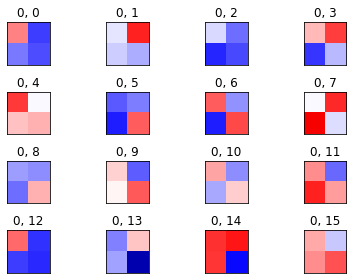

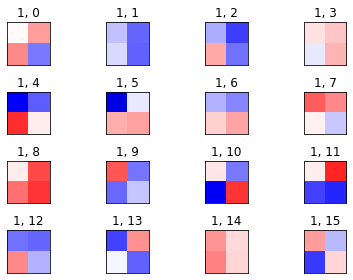

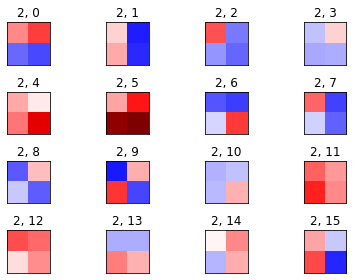

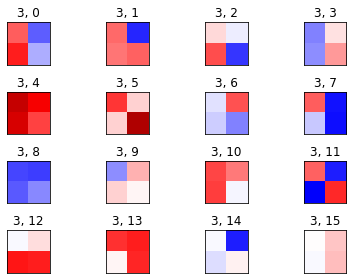

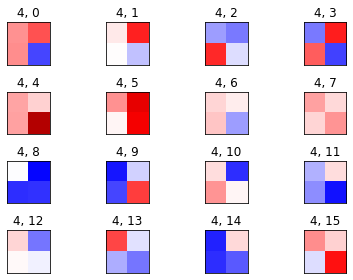

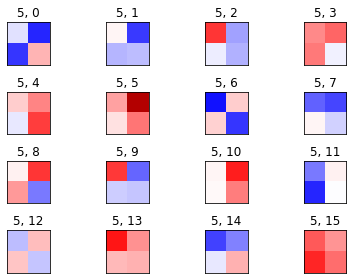

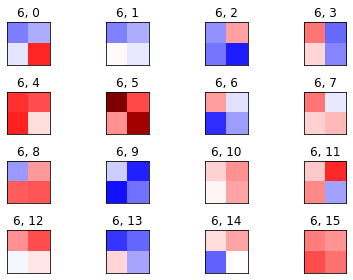

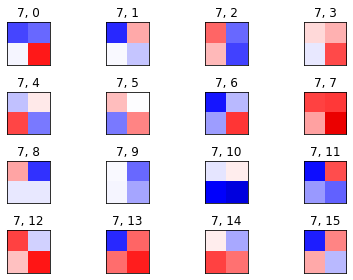

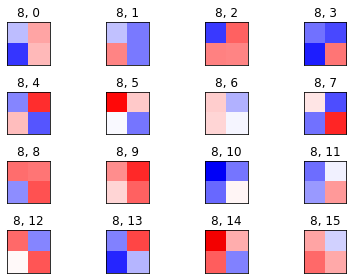

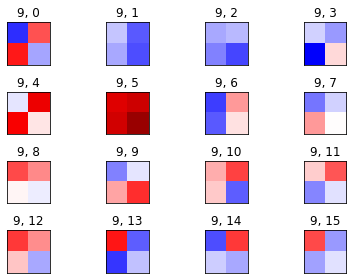

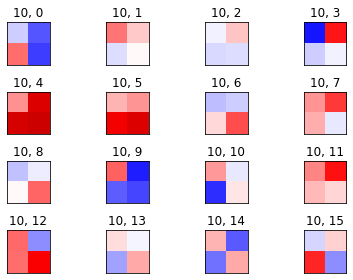

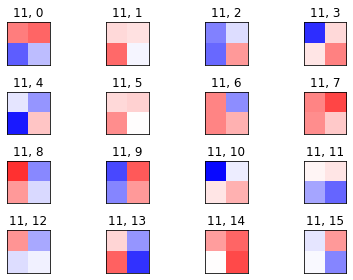

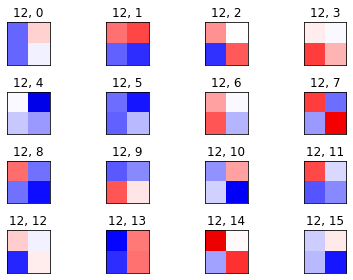

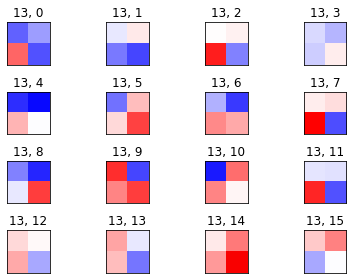

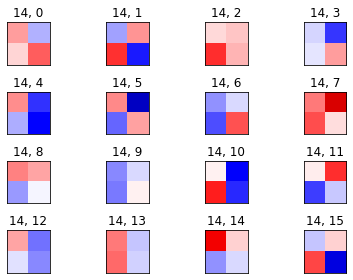

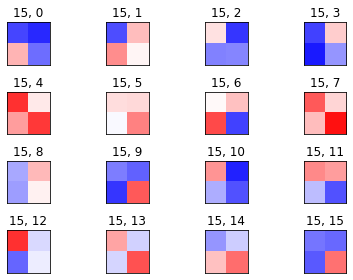

In [43]:
num_filters = conv_x2_kernel_np.shape[2]
channels = range(conv_x2_kernel_np.shape[2])
w_max = np.max(conv_x2_kernel_np)
w_min = np.min(conv_x2_kernel_np)

for channel in channels:
    # create figure and axes
    fig, axes = plt.subplots(4, 4)
    for idx, ax in enumerate(axes.flat):
        img = conv_x2_kernel_np[:, :, channel, idx]
        _ = ax.imshow(img, vmin=w_min, vmax=w_max, 
                      interpolation='nearest', cmap='seismic')
        _ = ax.set_xticks([])
        _ = ax.set_yticks([])
        _ = ax.set_title(f'{channel}, {idx}')
    fig.tight_layout()

In [ ]:

# iterate channels
for channel in channels:
    # iterate filters inside every channel
    for l, ax in enumerate(axes.flat):
        # get a single filter
        img = weights[:, :, channel, l]
        # put it on the grid
        ax.imshow(img, vmin=w_min, vmax=w_max, interpolation='nearest', cmap='seismic')
        # remove any labels from the axes
        ax.set_xticks([])
        ax.set_yticks([])
    # save figure
    plt.savefig(os.path.join(plot_dir, '{}-{}.png'.format(name, channel)), bbox_inches='tight')

[]

[]

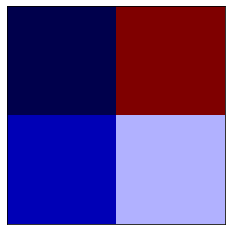

In [29]:
w0 = conv_x1_kernel_np[:, :, 0]
w_min = np.min(w0)
w_max = np.max(w0)

fig, ax = plt.subplots()
_ = ax.imshow(conv_x1_kernel_np[:, :, 0], vmin=w_min, vmax=w_max, 
          interpolation='nearest', cmap='seismic')
# remove any labels from the axes
_ = ax.set_xticks([])
_ = ax.set_yticks([])

In [ ]:
model.dynamics.position_fn.dense

In [39]:
import pickle

with open(model.files['parameters_pkl_file'], 'wb') as f:
    pickle.dump(model.params, f)

In [ ]:
model.sess.graph.collections

In [ ]:
model.sess.graph.get_collection

In [ ]:
model.dynamics.position_fn.summary()

In [ ]:
# Iterate over samples history and calculate observables for each sample.
# `lattice.calc_plaq_observables(samples)` calculates observables for each of
# the samples in the mini-batch.
actions_history = []
avg_plaquettes_history = []
top_charges_history = []
for idx, samples in enumerate(samples_history):
    t0 = time.time()
    observables = np.array(model.lattice.calc_plaq_observables(samples))
    actions, plaqs, charges = observables
    
    actions_history.append(actions)
    avg_plaquettes_history.append(plaqs)
    top_charges_history.append(charges)
    
    print(f'step: {idx}  '
          f'time / step: {time.time() - t0:^6.4g}  '
          f'avg action: {np.mean(actions):^6.4g}  '
          f'avg plaquette: {np.mean(plaqs):^6.4g} '
          f'top charge: {np.mean(charges):^6.4g}')

In [ ]:
_ = helpers.plot_run_data(model.data, 
                          model.params, 
                          model.steps_arr, 
                          model.figs_dir, 
                          skip_steps=1)

In [ ]:
#tf.reset_default_graph()
#model = GaugeModel(params=params,
#                   config=None,
#                   sess=None,
#                   conv_net=False,
#                   hmc=False,
#                   log_dir='../../gauge_logs_graph/run_25',
#                   restore=True)

In [ ]:
samples = np.random.randn(*model.samples.shape)
samples_history = []

In [ ]:
for i in range(500):
    t0 = time.time()
    samples = model.sess.run(model.x_out, feed_dict={model.x: samples})
    samples_history.append(samples)
    print(f'step: {i:^6.4g} time/step: {time.time() - t0:^6.4g}')

In [ ]:
samples_history_conv = np.array(samples_history_conv)
print(samples_history_conv.shape)

In [ ]:
import pickle
samples_history_file = os.path.join(model.info_dir, 'samples_history.pkl')
with open(samples_history_file, 'wb') as f:
    pickle.dump(samples_history_conv, f)